In [20]:
import geopandas as gpd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from alphashape import alphashape
from descartes import PolygonPatch
from tqdm import tqdm
import os
import xml.etree.ElementTree as ET

import pandas as pd
from shapely.geometry import Point
import os
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

import matsim
import pandas as pd
from collections import defaultdict
%matplotlib inline

from shapely.geometry import box
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

In [21]:
crs = 25832

# Lade die Shapefiles
unternehmen = gpd.read_file('input/companies_Total_reduced.shp')
pakete = gpd.read_file('input/vm-hochrechnung_matsim-punkte_epsg25832_mit_plz_v2.shp')
hannover = gpd.read_file('input/Region Hannover.shp')
landuse = gpd.read_file('input/gis_osm_landuse_a_free_1.shp')
landuse = landuse.to_crs(hannover.crs)
# Landuse-Daten auf die Region Hannover zuschneiden
landuse_clipped = gpd.clip(landuse, hannover)

pakete = pakete[pakete.total <= 1500]
plz = gpd.read_file('input/plz_osm_202132N.shp')
landuse = gpd.read_file('input/landuse.shp')
final_grid_h = gpd.read_file("output/final_grid_250_region_results_update.shp")
roads = gpd.read_file("input/gis_osm_roads_free_1.shp")
roads = roads.to_crs(epsg=crs)
vehicle_roads = [
    'residential', 
    'unclassified', 
    'tertiary', 
    'service', 
    'secondary', 
    'motorway', 
    'primary', 
    'trunk', 
    'living_street', 
    'trunk_link', 
    'primary_link', 
    'tertiary_link', 
    'secondary_link', 
]
filtered_roads = roads[roads['fclass'].isin(vehicle_roads)]



<Axes: >

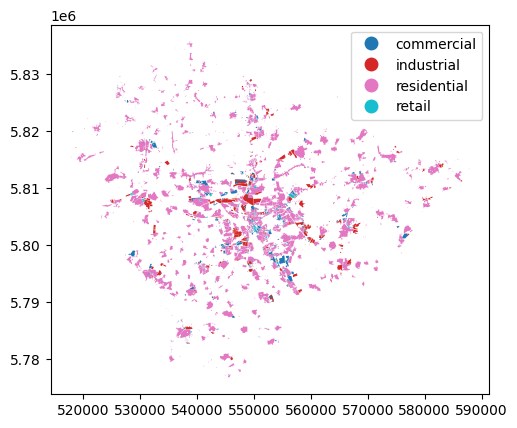

In [22]:
relevant_types = ["commercial", "industrial", "retail", "residential"]

landuse_filtered = landuse_clipped[landuse_clipped["fclass"].isin(relevant_types)]

# Plot zur Überprüfung
landuse_filtered.plot(column="fclass", legend=True)


C:\Users\bienzeisler\AppData\Local\Temp\ipykernel_11360\1975129620.py:26: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [mpatches.Patch(color=color, label=labels[label], edgecolor='k') for label, color in colors.items()]
C:\Users\bienzeisler\AppData\Local\Temp\ipykernel_11360\1975129620.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", len(unique_classes))  # Farbschema für verschiedene Kategorien


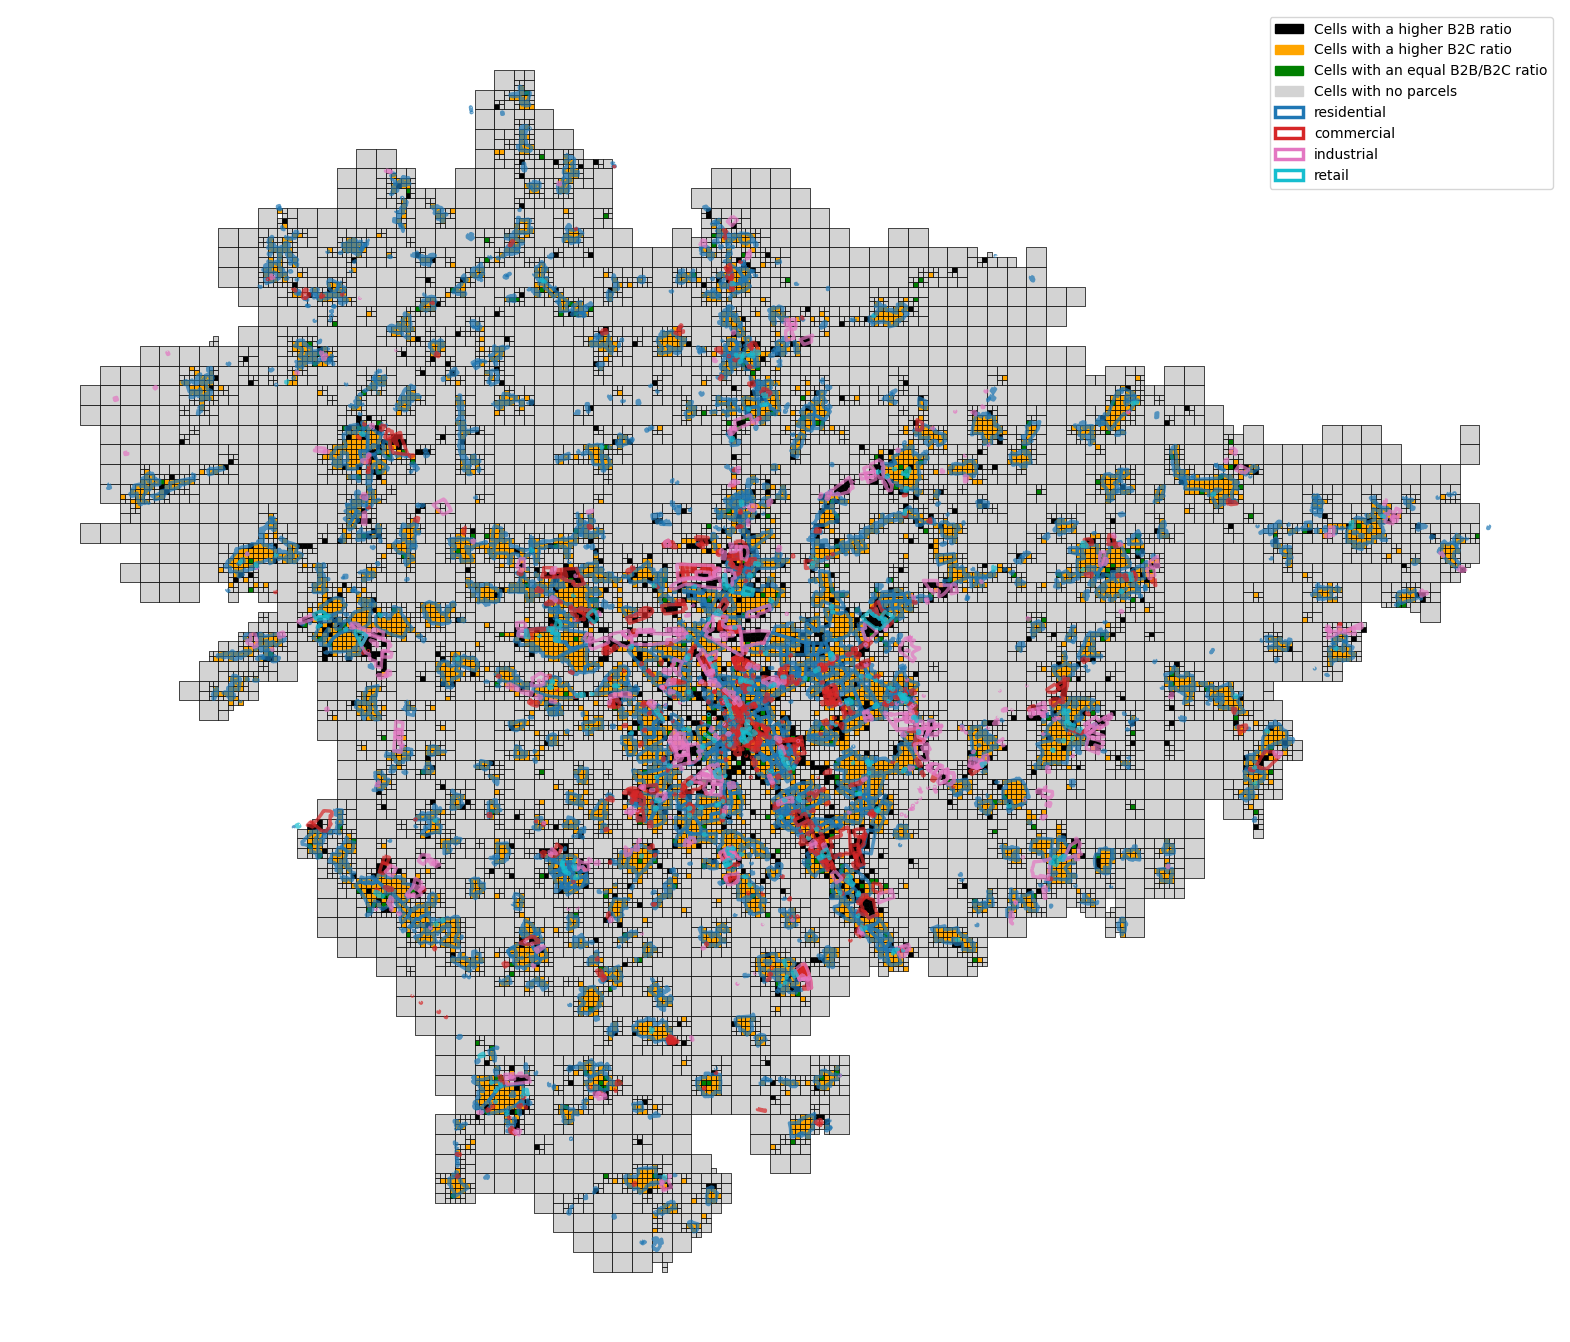

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define a custom colormap for delivery types
colors = {
    'b2b': 'black',
    'b2c': 'orange',
    'equal': 'green',
    'no': 'lightgray'  # White for "Cells with no parcels"
}

# Define new labels for the legend
labels = {
    'b2b': 'Cells with a higher B2B ratio',
    'b2c': 'Cells with a higher B2C ratio',
    'equal': 'Cells with an equal B2B/B2C ratio',
    'no': 'Cells with no parcels'
}

fig, ax = plt.subplots(figsize=(20, 20))

# Plot the grid cells with their delivery types
final_grid_h.plot(ax=ax, color=final_grid_h['delivery_t'].map(colors), edgecolor='k', linewidth=0.5)

# Create custom legend for delivery types
legend_handles = [mpatches.Patch(color=color, label=labels[label], edgecolor='k') for label, color in colors.items()]

# Einzigartige fclass-Werte abrufen und Farben zuweisen
unique_classes = landuse_filtered["fclass"].unique()
cmap = plt.cm.get_cmap("tab10", len(unique_classes))  # Farbschema für verschiedene Kategorien
color_dict = {cls: cmap(i) for i, cls in enumerate(unique_classes)}

# Polygone einzeln plotten mit spezifischen Randfarben und zur Legende hinzufügen
for cls in unique_classes:
    subset = landuse_filtered[landuse_filtered["fclass"] == cls]
    subset.plot(ax=ax, edgecolor=color_dict[cls], facecolor="none", linewidth=2.5, alpha = 0.7)

    # Legenden-Eintrag für die Landnutzungen
    legend_handles.append(mpatches.Patch(edgecolor=color_dict[cls], facecolor="none", label=cls, linewidth=2.5))

# Add legend with both delivery types and landuse labels
ax.legend(handles=legend_handles, loc='upper right')

# Remove the frame (spines) around the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# If you also want to remove the x and y axis ticks and labels:
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.show()
# fig.savefig('b2b_res.png', dpi=300 , bbox_inches='tight')

In [24]:
final_grid_h.to_file("b2bandb2c_hannover.shp", driver="ESRI Shapefile")
landuse_filtered.to_file("landuse_hannover.shp", driver="ESRI Shapefile")

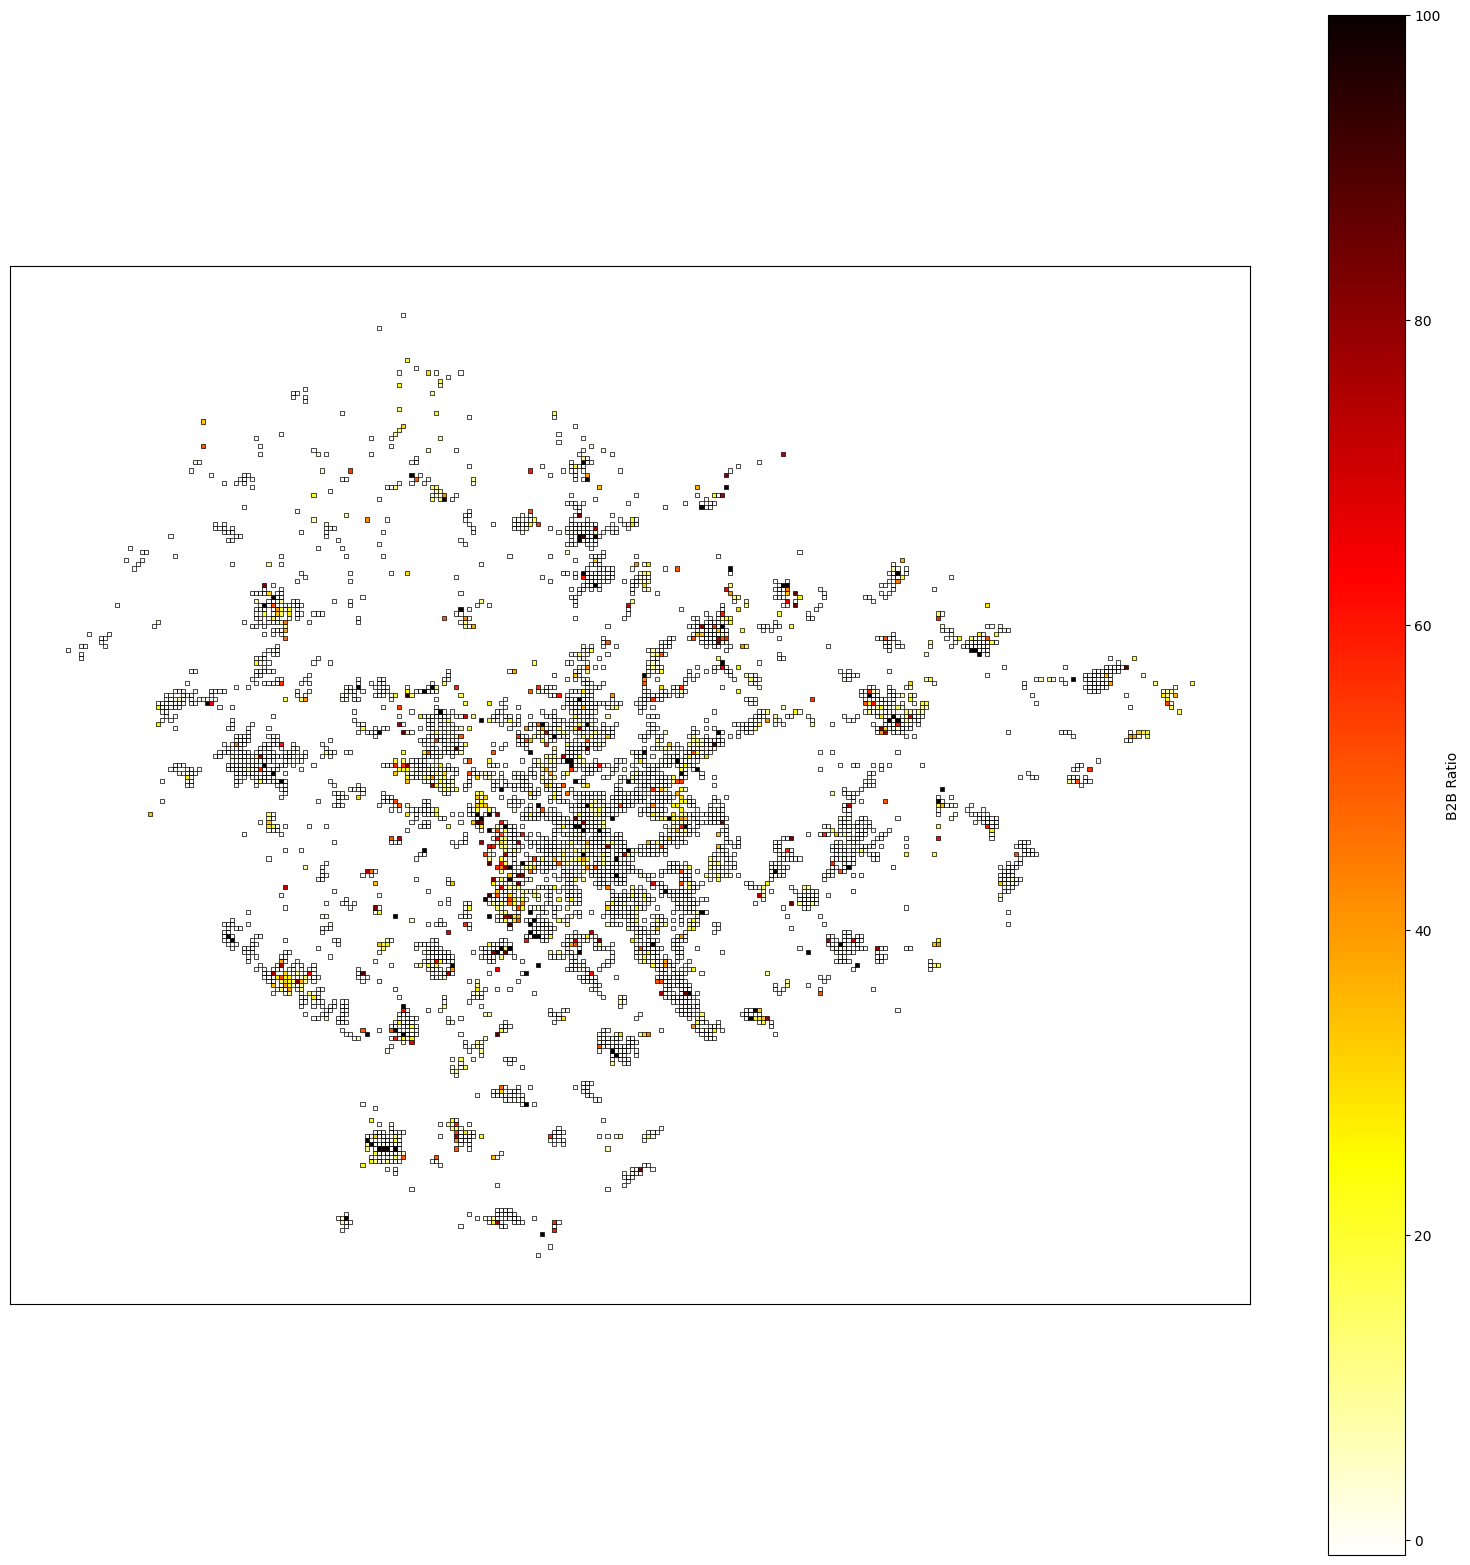

In [25]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(20, 20))

# Erstellen einer umgedrehten Farbskala für b2b_ratio
cmap = plt.cm.hot_r  # "hot" umgedreht
norm = mcolors.Normalize(vmin=final_grid_h["b2b_ratio"].min(), vmax=final_grid_h["b2b_ratio"].max())

# Farben zuweisen: Wenn b2b_ratio < 0, dann transparente Füllung
colors = [
    cmap(norm(val)) if val >= 0 else (1, 1, 1, 0)  # RGBA (1,1,1,0) für volle Transparenz
    for val in final_grid_h["b2b_ratio"]
]

# Plot mit Farben
final_grid_h[final_grid_h.b2b_ratio > 0].plot(
    ax=ax, 
    facecolor=colors,  # Setzt die Zellfarben korrekt
    edgecolor="black", 
    linewidth=0.5
)

# Farblegende hinzufügen
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation="vertical", label="B2B Ratio")

# Entfernen der Achsenbeschriftungen
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.show()


In [26]:
# Daten erneut definieren
data = {
    "Year": np.array([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023,
                      2024, 2025, 2026, 2027, 2028]),
    "Value": np.array([2.780, 2.950, 3.160, 3.350, 3.520, 3.650, 4.050, 4.510, 4.150, 4.175,
                       4.200, 4.300, 4.420, 4.550, 4.680])
}
df = pd.DataFrame(data)

df_estimated = df[df.Year > 2023]
df = df[df.Year <=2023]
df_filtered = df[df["Year"] != 2021]  # 2021 entfernen




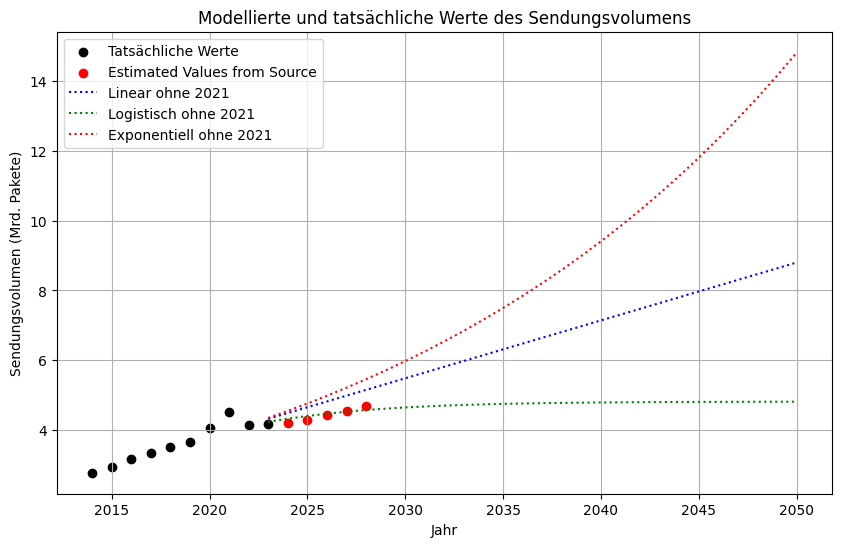

,Model,RMSE,MAE,AIC
0,Linear mit 2021,0.173048,0.115061,-31.083757
1,Linear ohne 2021,0.093280,0.059946,-38.698745
2,Logistisch mit 2021,0.156345,0.113108,-31.113781
3,Logistisch ohne 2021,0.069310,0.050349,-42.044898
4,Exponentiell mit 2021,0.189408,0.131065,-29.277035
5,Exponentiell ohne 2021,0.114438,0.082289,-35.018951


In [27]:
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Exponentielles Modell
def exponential_function(x, a, b):
    return a * np.exp(b * (x - 2028))

# Logistisches Modell
def logistic_function(x, a, b, c):
    return a / (1 + np.exp(-b * (x - c)))

# Funktionen zur Berechnung der Fehlermaße
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def calculate_aic(y_true, y_pred, num_params):
    """ Akaike Information Criterion (AIC) berechnen """
    residuals = y_true - y_pred
    n = len(y_true)
    rss = np.sum(residuals**2)
    return n * np.log(rss / n) + 2 * num_params

# Lineares Modell mit allen Daten
X_linear = df["Year"].values.reshape(-1, 1)
model_linear = LinearRegression()
model_linear.fit(X_linear, df["Value"])
y_pred_linear = model_linear.predict(X_linear)

# Lineares Modell ohne 2021
df_filtered = df[df["Year"] != 2021]  # 2021 entfernen
X_linear_filtered = df_filtered["Year"].values.reshape(-1, 1)
model_linear_filtered = LinearRegression()
model_linear_filtered.fit(X_linear_filtered, df_filtered["Value"])
y_pred_linear_filtered = model_linear_filtered.predict(X_linear_filtered)

popt, _ = curve_fit(logistic_function, df["Year"], df["Value"], p0=[10, 0.1, 2020])
y_pred_logistic = logistic_function(df["Year"], *popt)

popt_filtered, _ = curve_fit(logistic_function, df_filtered["Year"], df_filtered["Value"], p0=[10, 0.1, 2020])
y_pred_logistic_filtered = logistic_function(df_filtered["Year"], *popt_filtered)


# Fitten des exponentiellen Modells mit allen Daten
exp_params, _ = curve_fit(exponential_function, df["Year"], df["Value"], p0=[1, 0.05])
y_pred_exponential = exponential_function(df["Year"], *exp_params)

# Fitten des exponentiellen Modells ohne 2021
exp_params_filtered, _ = curve_fit(exponential_function, df_filtered["Year"], df_filtered["Value"], p0=[1, 0.05])
y_pred_exponential_filtered = exponential_function(df_filtered["Year"], *exp_params_filtered)

# Fehlermaße aktualisieren
metrics = pd.DataFrame({
    "Model": ["Linear mit 2021", "Linear ohne 2021", 
              "Logistisch mit 2021", "Logistisch ohne 2021",
              "Exponentiell mit 2021", "Exponentiell ohne 2021"],
    "RMSE": [
        rmse(df["Value"], y_pred_linear),
        rmse(df_filtered["Value"], y_pred_linear_filtered),
        rmse(df["Value"], y_pred_logistic),
        rmse(df_filtered["Value"], y_pred_logistic_filtered),
        rmse(df["Value"], y_pred_exponential),
        rmse(df_filtered["Value"], y_pred_exponential_filtered),
    ],
    "MAE": [
        mae(df["Value"], y_pred_linear),
        mae(df_filtered["Value"], y_pred_linear_filtered),
        mae(df["Value"], y_pred_logistic),
        mae(df_filtered["Value"], y_pred_logistic_filtered),
        mae(df["Value"], y_pred_exponential),
        mae(df_filtered["Value"], y_pred_exponential_filtered),
    ],
    "AIC": [
        calculate_aic(df["Value"], y_pred_linear, 2),
        calculate_aic(df_filtered["Value"], y_pred_linear_filtered, 2),
        calculate_aic(df["Value"], y_pred_logistic, 3),
        calculate_aic(df_filtered["Value"], y_pred_logistic_filtered, 3),
        calculate_aic(df["Value"], y_pred_exponential, 2),
        calculate_aic(df_filtered["Value"], y_pred_exponential_filtered, 2),
    ]
})

# Da 2021 in den gefilterten Daten fehlt, müssen wir das Jahr ebenfalls aus den X-Werten entfernen
df_filtered_years = df_filtered["Year"].values  # Jahre ohne 2021

# Zukunftsprognose für jedes Jahr bis 2050
years_future = np.arange(2023, 2051, 1)

# Zukunftsprognosen bis 2050
X_future = years_future.reshape(-1, 1)

y_future_linear = model_linear.predict(X_future)
y_future_linear_filtered = model_linear_filtered.predict(X_future)
y_future_log = logistic_function(years_future, *popt)
y_future_log_filtered = logistic_function(years_future, *popt_filtered)
y_future_exp = exponential_function(years_future, *exp_params)
y_future_exp_filtered = exponential_function(years_future, *exp_params_filtered)

# Ergebnisse zusammenfassen
forecast_df = pd.DataFrame({
    "Year": years_future,
    "Linear mit 2021": y_future_linear,
    "Linear ohne 2021": y_future_linear_filtered,
    "Logistisch mit 2021": y_future_log,
    "Logistisch ohne 2021": y_future_log_filtered,
    "Exponentiell mit 2021": y_future_exp,
    "Exponentiell ohne 2021": y_future_exp_filtered,
})


# Visualisierung der Modelle mit und ohne 2021 korrekt angepasst
plt.figure(figsize=(10, 6))

# Originale Werte
plt.scatter(df["Year"], df["Value"], color="black", label="Tatsächliche Werte")
plt.scatter(df_estimated["Year"], df_estimated["Value"], color="red", label="Estimated Values from Source")

# Modellierte Werte mit 2021
# plt.plot(df["Year"], y_pred_linear, linestyle="--", color="blue", label="Linear mit 2021")
# plt.plot(df["Year"], y_pred_logistic, linestyle="--", color="green", label="Logistisch mit 2021")
# plt.plot(df["Year"], y_pred_exponential, linestyle="--", color="red", label="Exponentiell mit 2021")

# Modellierte Werte ohne 2021 (angepasste x-Werte)
# plt.plot(df_filtered_years, y_pred_linear_filtered, linestyle="-", color="blue", label="Linear ohne 2021")
# plt.plot(df_filtered_years, y_pred_logistic_filtered, linestyle="-", color="green", label="Logistisch ohne 2021")
# plt.plot(df_filtered_years, y_pred_exponential_filtered, linestyle="-", color="red", label="Exponentiell ohne 2021")


# Prognosen als Linien
# plt.plot(years_future, y_future_linear, linestyle=":", color="blue", label="Linear mit 2021")
plt.plot(years_future, y_future_linear_filtered, linestyle=":", color="blue", label="Linear ohne 2021")
# plt.plot(years_future, y_future_log, linestyle=":", color="green", label="Logistisch mit 2021")
plt.plot(years_future, y_future_log_filtered, linestyle=":", color="green", label="Logistisch ohne 2021")
# plt.plot(years_future, y_future_exp, linestyle=":", color="red", label="Exponentiell mit 2021")
plt.plot(years_future, y_future_exp_filtered, linestyle=":", color="red", label="Exponentiell ohne 2021")



plt.xlabel("Jahr")
plt.ylabel("Sendungsvolumen (Mrd. Pakete)")
plt.title("Modellierte und tatsächliche Werte des Sendungsvolumens")
plt.legend()
plt.grid(True)
plt.show()

# Ergebnisse anzeigen
metrics


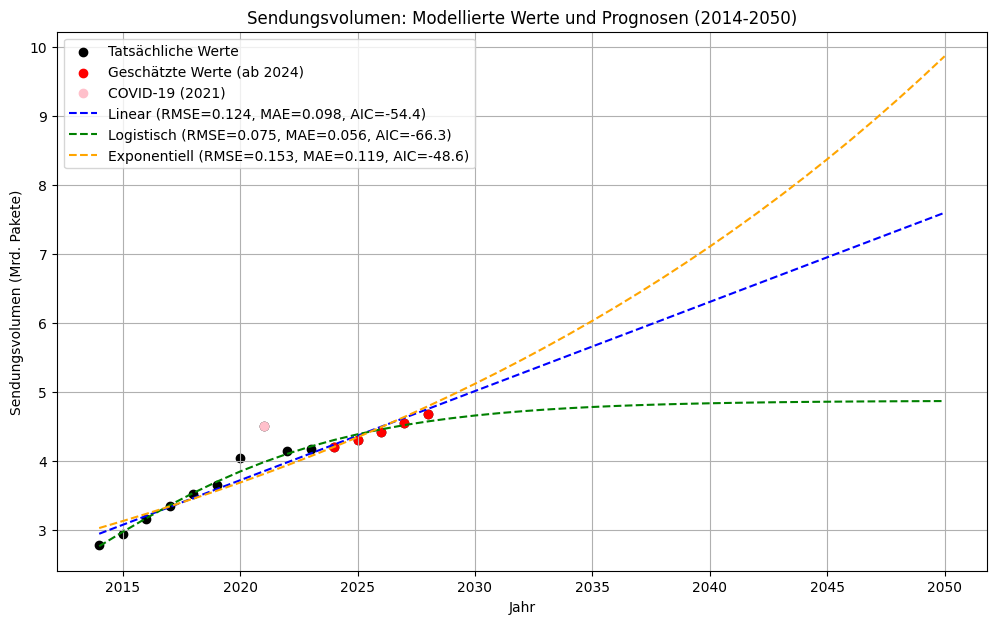

In [28]:
# Neue Datengrundlage erneut definieren und Modelle fitten
data = {
    "Year": np.array([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023,
                      2024, 2025, 2026, 2027, 2028]),
    "Value": np.array([2.780, 2.950, 3.160, 3.350, 3.520, 3.650, 4.050, 4.510, 4.150, 4.175,
                       4.200, 4.300, 4.420, 4.550, 4.680])
}
# DataFrame erstellen
df = pd.DataFrame(data)

# Referenzjahr 2019 als Basis für relative Werte nehmen
reference_value = df[df["Year"] == 2019]["Value"].values[0]

# Relative Werte berechnen (Wert / 2019-Wert)
df["Relative_Value_2"] = df["Value"] / reference_value
df["Relative_Value"] = df["Value"] 

df_estimated = df[df.Year > 2023]
# df = df[df.Year <= 2023]
df_filtered = df[df["Year"] != 2021]

# Lineares Modell
X_linear_filtered = df_filtered["Year"].values.reshape(-1, 1)
model_linear_filtered = LinearRegression().fit(X_linear_filtered, df_filtered["Relative_Value"])

# Logistisches Modell mit angepassten Startwerten erneut fitten
popt_filtered, _ = curve_fit(logistic_function, df_filtered["Year"], df_filtered["Relative_Value"], p0=[5, 0.2, 2025], maxfev=5000)

# Exponentielles Modell fitten
exp_params_filtered, _ = curve_fit(exponential_function, df_filtered["Year"], df_filtered["Relative_Value"], p0=[1, 0.05])

# Prognose für 2014-2050
years_forecast = np.arange(2014, 2051)
y_linear_forecast_data = model_linear_filtered.predict(years_forecast.reshape(-1, 1))
y_logistic_forecast_data = logistic_function(years_forecast, *popt_filtered)
y_exponential_forecast_data = exponential_function(years_forecast, *exp_params_filtered)

# Gütemaße berechnen (für vorhandene Jahre)
y_linear_pred = model_linear_filtered.predict(X_linear_filtered)
y_logistic_pred = logistic_function(df_filtered["Year"], *popt_filtered)
y_exponential_pred = exponential_function(df_filtered["Year"], *exp_params_filtered)

metrics_df = pd.DataFrame({
    "Model": ["Linear", "Logistisch", "Exponentiell"],
    "RMSE": [rmse(df_filtered["Relative_Value"], y_linear_pred),
             rmse(df_filtered["Relative_Value"], y_logistic_pred),
             rmse(df_filtered["Relative_Value"], y_exponential_pred)],
    "MAE": [mae(df_filtered["Relative_Value"], y_linear_pred),
            mae(df_filtered["Relative_Value"], y_logistic_pred),
            mae(df_filtered["Relative_Value"], y_exponential_pred)],
    "AIC": [calculate_aic(df_filtered["Relative_Value"], y_linear_pred, 2),
            calculate_aic(df_filtered["Relative_Value"], y_logistic_pred, 3),
            calculate_aic(df_filtered["Relative_Value"], y_exponential_pred, 2)]
})

# Plot erstellen
plt.figure(figsize=(12, 7))
plt.scatter(df["Year"], df["Relative_Value"], color="black", label="Tatsächliche Werte")
plt.scatter(df_estimated["Year"], df_estimated["Relative_Value"], color="red", label="Geschätzte Werte (ab 2024)")
plt.scatter(df[df.Year == 2021]["Year"], df[df.Year == 2021]["Relative_Value"], color="pink", label="COVID-19 (2021)")

# Prognoselinien von 2014 bis 2050 mit Gütemaßen in Legende
plt.plot(years_forecast, y_linear_forecast_data, linestyle="--", 
         label=f"Linear (RMSE={metrics_df.iloc[0,1]:.3f}, MAE={metrics_df.iloc[0,2]:.3f}, AIC={metrics_df.iloc[0,3]:.1f})", color= 'blue')
plt.plot(years_forecast, y_logistic_forecast_data, linestyle="--", 
         label=f"Logistisch (RMSE={metrics_df.iloc[1,1]:.3f}, MAE={metrics_df.iloc[1,2]:.3f}, AIC={metrics_df.iloc[1,3]:.1f})", color= 'green')
plt.plot(years_forecast, y_exponential_forecast_data, linestyle="--", 
         label=f"Exponentiell (RMSE={metrics_df.iloc[2,1]:.3f}, MAE={metrics_df.iloc[2,2]:.3f}, AIC={metrics_df.iloc[2,3]:.1f})", color = "orange")

plt.xlabel("Jahr")
plt.ylabel("Sendungsvolumen (Mrd. Pakete)")
plt.title("Sendungsvolumen: Modellierte Werte und Prognosen (2014-2050)")
plt.legend()
plt.grid(True)
plt.show()


In [29]:
from prophet import Prophet

# ----- Daten vorbereiten -----
file_path = "input/Parcels19_20_21_inter.xlsx"
xls = pd.ExcelFile(file_path)
df1 = pd.read_excel(xls, sheet_name='Tabelle1')

df1_cleaned = df1.iloc[1:, :4]
df1_cleaned.columns = ["Week", "2019", "2020", "2021"]
df1_cleaned = df1_cleaned.astype({"Week": int, "2019": float, "2020": float, "2021": float})

# Durchschnittliches Jahresvolumen berechnen
df1_cleaned["avg_2019"] = df1_cleaned["2019"].mean()
df1_cleaned["avg_2020"] = df1_cleaned["2020"].mean()
df1_cleaned["avg_2021"] = df1_cleaned["2021"].mean()

# Relativer Wochenverlauf pro Jahr
df1_cleaned["rel_2019"] = df1_cleaned["2019"] / df1_cleaned["avg_2019"]
df1_cleaned["rel_2020"] = df1_cleaned["2020"] / df1_cleaned["avg_2020"]
df1_cleaned["rel_2021"] = df1_cleaned["2021"] / df1_cleaned["avg_2021"]

# Sicherstellen, dass alle Werte numerisch sind
df1_cleaned[["rel_2019", "rel_2020", "rel_2021"]] = df1_cleaned[["rel_2019", "rel_2020", "rel_2021"]].apply(pd.to_numeric, errors='coerce')

df1_cleaned = df1_cleaned[df1_cleaned.Week < 53]

# Durchschnitt über alle Jahre berechnen
df_sarima_avg = df1_cleaned.melt(id_vars=["Week"], value_vars=["rel_2019", "rel_2020", "rel_2021"], value_name="Relative Volume")
df_sarima_avg["Relative Volume"] = pd.to_numeric(df_sarima_avg["Relative Volume"], errors='coerce')


# ----- Glättung der Zeitreihen -----
def smooth_series(series, window=5):
    return series.rolling(window=window, center=True, min_periods=1).mean()

df1_cleaned["smoothed_2019"] = smooth_series(df1_cleaned["rel_2019"])
df1_cleaned["smoothed_2020"] = smooth_series(df1_cleaned["rel_2020"])
df1_cleaned["smoothed_2021"] = smooth_series(df1_cleaned["rel_2021"])

df1_cleaned["rel_median"] = df1_cleaned[["rel_2019", "rel_2020", "rel_2021"]].median(axis=1, skipna=True)
df1_cleaned["rel_avg"] = df1_cleaned[["rel_2019", "rel_2020", "rel_2021"]].mean(axis=1, skipna=True)

# Setze Wochen als Index mit wöchentlichem Zeitstempel
df1_cleaned["date_index"] = pd.date_range(start="2020-01-01", periods=52, freq="W")
df1_cleaned.set_index("date_index", inplace=True)

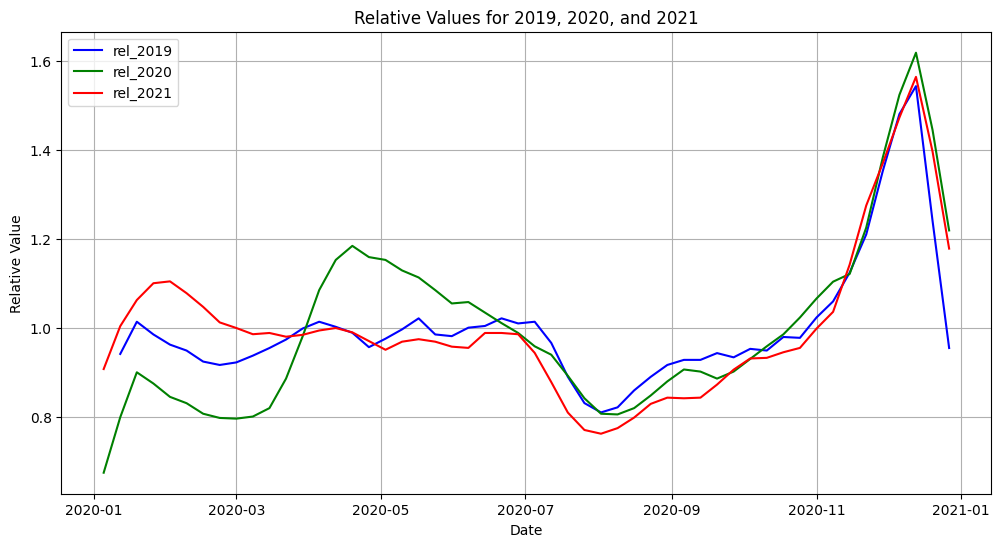

In [126]:
# Plot the relative values for 2019, 2020, and 2021
plt.figure(figsize=(12, 6))

plt.plot(df1_cleaned.index, df1_cleaned["rel_2019"], label="rel_2019", color="blue")
plt.plot(df1_cleaned.index, df1_cleaned["rel_2020"], label="rel_2020", color="green")
plt.plot(df1_cleaned.index, df1_cleaned["rel_2021"], label="rel_2021", color="red")

plt.xlabel("Date")
plt.ylabel("Relative Value")
plt.title("Relative Values for 2019, 2020, and 2021")
plt.legend()
plt.grid(True)
plt.show()

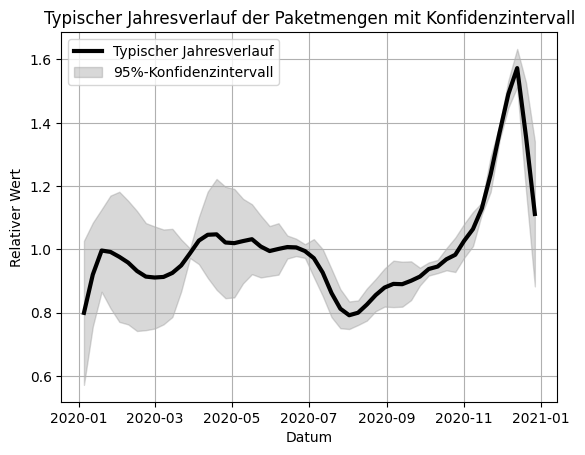

In [36]:
def gewichteter_mittelwert_ci(row, weights={"rel_2019": 0.35, "rel_2020": 0.3, "rel_2021": 0.35}):
    values = np.array([row["rel_2019"], row["rel_2020"], row["rel_2021"]])
    weights_array = np.array([weights["rel_2019"], weights["rel_2020"], weights["rel_2021"]])

    # Werte mit NaN ausschließen
    valid = ~np.isnan(values)
    if valid.sum() == 0:
        return pd.Series({"mean": np.nan, "std": np.nan, "ci_lower": np.nan, "ci_upper": np.nan})
    
    # gewichteter Mittelwert
    weighted_mean = np.average(values[valid], weights=weights_array[valid])

    # gewichtete Standardabweichung berechnen
    weighted_variance = np.average((values[valid]-weighted_mean)**2, weights=weights_array[valid])
    weighted_std = np.sqrt(weighted_variance)

    # 95%-Konfidenzintervall berechnen (±1.96 Standardabweichungen)
    ci_lower = weighted_mean - 1.96 * weighted_std
    ci_upper = weighted_mean + 1.96 * weighted_std

    row ["typischer_verlauf"] = weighted_mean

    return pd.Series({
        "mean": weighted_mean, 
        "std": weighted_std, 
        "ci_lower": ci_lower, 
        "ci_upper": ci_upper
    })

df_ci = df1_cleaned.apply(gewichteter_mittelwert_ci, axis=1)

# Typischer Verlauf mit Konfidenzintervall
plt.plot(df1_cleaned.index, df_ci["mean"], 
         label="Typischer Jahresverlauf", linewidth=3, color="black")

# Konfidenzintervall plotten
plt.fill_between(df1_cleaned.index, 
                 df_ci["ci_lower"], 
                 df_ci["ci_upper"], 
                 color="grey", alpha=0.3, 
                 label="95%-Konfidenzintervall")

plt.xlabel("Datum")
plt.ylabel("Relativer Wert")
plt.title("Typischer Jahresverlauf der Paketmengen mit Konfidenzintervall")
plt.legend()
plt.grid(True)
plt.show()

gen	nevals
0  	20    
1  	11    
2  	11    
3  	15    
4  	10    
5  	7     
6  	12    
7  	14    
8  	12    
9  	4     
10 	15    
11 	12    
12 	12    
13 	14    
14 	13    
15 	14    
16 	12    
17 	14    
18 	14    
19 	17    
20 	8     
21 	10    
22 	12    
23 	12    
24 	16    
25 	7     
26 	5     
27 	12    
28 	12    
29 	13    
30 	13    
31 	15    
32 	11    
33 	16    
34 	13    
35 	14    
36 	17    
37 	14    
38 	15    
39 	15    
40 	14    
41 	10    
42 	11    
43 	13    
44 	11    
45 	15    
46 	9     
47 	10    
48 	15    
49 	8     
50 	10    
Optimierte Parameter: alpha_base=0.576, random_scale=0.014, xmas_boost_factor=1.266, xmas_reduction_factor=0.749, xmas_start_week=45, xmas_end_week=50


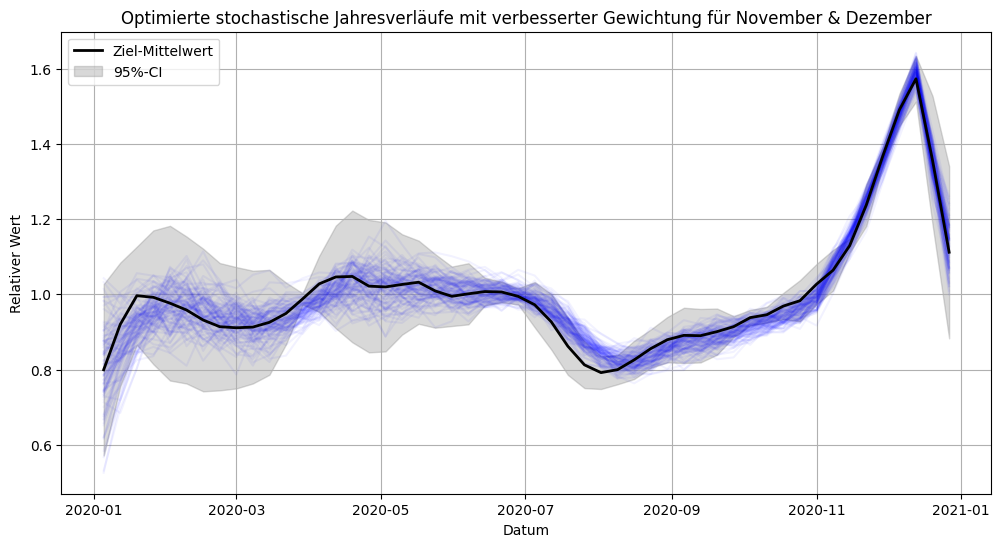

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

# === 📌 GA Einstellungen ===
num_simulations = 100  # Anzahl der Monte-Carlo-Simulationen
num_generations = 50   # Anzahl der Generationen
pop_size = 20          # Größe der Population

# Ziel: df_ci["mean"]
target_mean = df_ci["mean"].values

# **📌 Gewichtungsfaktor für November & Dezember**
weight_nov_dec = 3.0  # Fehler im November & Dezember wird dreifach gewichtet

# **Fitness-Funktion (Minimierung des Fehlers)**
def evaluate(individual):
    alpha_base, random_scale, xmas_boost_factor, xmas_reduction_factor, xmas_start_week, xmas_end_week = individual

    # **✅ Sicherstellen, dass Werte sinnvoll sind**
    random_scale = max(0.001, random_scale)  # Noise ≥ 0.001
    alpha_base = max(0.5, alpha_base)  # alpha_base ≥ 0.5
    xmas_start_week = int(round(xmas_start_week))
    xmas_end_week = int(round(xmas_end_week))
    xmas_reduction_factor = min(1.0, max(0.3, xmas_reduction_factor))  # Faktor zwischen 0.3 und 1.0

    simulated_years = np.zeros((num_simulations, len(df_ci)))

    for i in range(num_simulations):
        sampled_trajectory = np.zeros(len(df_ci))
        sampled_trajectory[0] = np.random.normal(df_ci["mean"].iloc[0], df_ci["std"].iloc[0])

        for t in range(1, len(df_ci)):
            week_num = df_ci.index[t].week

            if xmas_start_week <= week_num <= xmas_end_week:
                alpha = alpha_base + 0.2  
                scale_factor = xmas_boost_factor  
            elif week_num > xmas_end_week:  # 🎯 Reduktion nach Weihnachten!
                alpha = alpha_base
                scale_factor = xmas_reduction_factor
            else:
                alpha = alpha_base
                scale_factor = 1.0

            sampled_trajectory[t] = (
                alpha * sampled_trajectory[t-1] +  
                (1 - alpha) * np.random.normal(df_ci["mean"].iloc[t] * scale_factor, df_ci["std"].iloc[t]) +
                np.random.normal(0, random_scale)
            )

        simulated_years[i, :] = sampled_trajectory

    # Mittelwert über alle Simulationen berechnen
    mean_simulation = np.mean(simulated_years, axis=0)

    # **📌 MSE mit Gewichtung für November & Dezember**
    mse = np.mean((mean_simulation - target_mean) ** 2)
    
    # **Fix: Extraktion der November & Dezember Indizes als Integer-Maske**
    nov_dec_mask = (df_ci.index.month == 11) | (df_ci.index.month == 12)
    mse_nov_dec = np.mean((mean_simulation[nov_dec_mask] - target_mean[nov_dec_mask]) ** 2)

    total_loss = mse + weight_nov_dec * mse_nov_dec  # November & Dezember 3x gewichtet
    
    return (total_loss,)  # Minimierung

# === 🧬 Genetischer Algorithmus einrichten ===
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimierung
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_alpha", np.random.uniform, 0.5, 0.8)  # Alpha-Bereich (min 0.5)
toolbox.register("attr_noise", np.random.uniform, 0.001, 0.05)  # Noise ≥ 0.001
toolbox.register("attr_xmas", np.random.uniform, 1.1, 2.0)  # Weihnachts-Boost
toolbox.register("attr_xmas_reduction", np.random.uniform, 0.3, 1.0)  # Weihnachts-Reduktion nach Peak
toolbox.register("attr_xmas_start", np.random.uniform, 40, 48)  # Start zwischen Woche 40 und 48
toolbox.register("attr_xmas_end", np.random.uniform, 49, 52)  # Ende zwischen Woche 49 und 52

toolbox.register("individual", tools.initCycle, creator.Individual, 
                 (toolbox.attr_alpha, toolbox.attr_noise, toolbox.attr_xmas, toolbox.attr_xmas_reduction, toolbox.attr_xmas_start, toolbox.attr_xmas_end), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.05, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# === 🚀 GA ausführen ===
population = toolbox.population(n=pop_size)
algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=num_generations, verbose=True)

# Beste Lösung extrahieren
best_ind = tools.selBest(population, k=1)[0]
alpha_opt, noise_opt, xmas_opt, xmas_reduction_opt, xmas_start_opt, xmas_end_opt = best_ind
print(f"Optimierte Parameter: alpha_base={alpha_opt:.3f}, random_scale={noise_opt:.3f}, xmas_boost_factor={xmas_opt:.3f}, xmas_reduction_factor={xmas_reduction_opt:.3f}, xmas_start_week={int(xmas_start_opt)}, xmas_end_week={int(xmas_end_opt)}")

# === 🎨 Finale Simulation mit optimierten Parametern ===
simulated_years_opt = pd.DataFrame(index=df_ci.index)
for i in range(num_simulations):
    sampled_trajectory = np.zeros(len(df_ci))
    sampled_trajectory[0] = np.random.normal(df_ci["mean"].iloc[0], df_ci["std"].iloc[0])

    for t in range(1, len(df_ci)):
        week_num = df_ci.index[t].week

        if int(xmas_start_opt) <= week_num <= int(xmas_end_opt):
            alpha = alpha_opt + 0.2  
            scale_factor = xmas_opt  
        elif week_num > int(xmas_end_opt):  # 🎯 Reduktion nach Weihnachten!
            alpha = alpha_opt
            scale_factor = xmas_reduction_opt
        else:
            alpha = alpha_opt
            scale_factor = 1.0

        sampled_trajectory[t] = (
            alpha * sampled_trajectory[t-1] +  
            (1 - alpha) * np.random.normal(df_ci["mean"].iloc[t] * scale_factor, df_ci["std"].iloc[t]) +
            np.random.normal(0, max(0.001, noise_opt))
        )

    simulated_years_opt[f"Simulation_{i+1}"] = sampled_trajectory

# === 📈 Visualisierung ===
plt.figure(figsize=(12, 6))

for i in range(num_simulations):
    plt.plot(df_ci.index, simulated_years_opt[f"Simulation_{i+1}"], alpha=0.05, color="blue")

plt.plot(df_ci.index, df_ci["mean"], color="black", linewidth=2, label="Ziel-Mittelwert")
plt.fill_between(df_ci.index, df_ci["ci_lower"], df_ci["ci_upper"], color="grey", alpha=0.3, label="95%-CI")

plt.xlabel("Datum")
plt.ylabel("Relativer Wert")
plt.title("Optimierte stochastische Jahresverläufe mit verbesserter Gewichtung für November & Dezember")
plt.legend()
plt.grid(True)
plt.show()


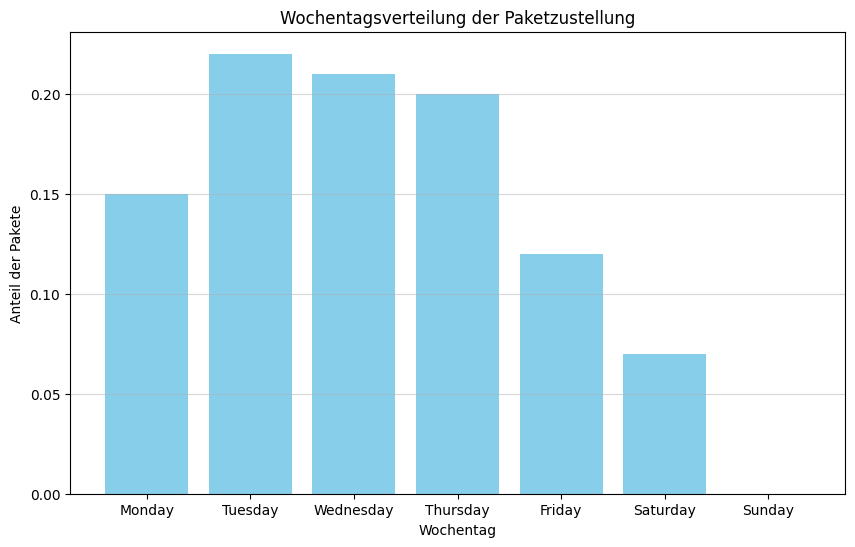

In [31]:
# Wochentagsverteilung basierend auf Zusteller-Erfahrung (Montag-Samstag)
weekday_distribution = {
    "Monday": 0.15,   
    "Tuesday": 0.22,  
    "Wednesday": 0.21,  
    "Thursday": 0.20,  
    "Friday": 0.12,  
    "Saturday": 0.07,
    "Sunday": 0
}

df_weekdays = pd.DataFrame({
    "Weekday": weekday_distribution.keys(),
    "Distribution": weekday_distribution.values()
})

plt.figure(figsize=(10,6))

plt.bar(df_weekdays["Weekday"], df_weekdays["Distribution"], color="skyblue")

plt.xlabel("Wochentag")
plt.ylabel("Anteil der Pakete")
plt.title("Wochentagsverteilung der Paketzustellung")
plt.grid(axis='y', alpha=0.5)

plt.show()




C:\Users\bienzeisler\AppData\Local\Temp\ipykernel_11360\1326204347.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_known_filtered["log_value"] = np.log(df_known_filtered["Value"])


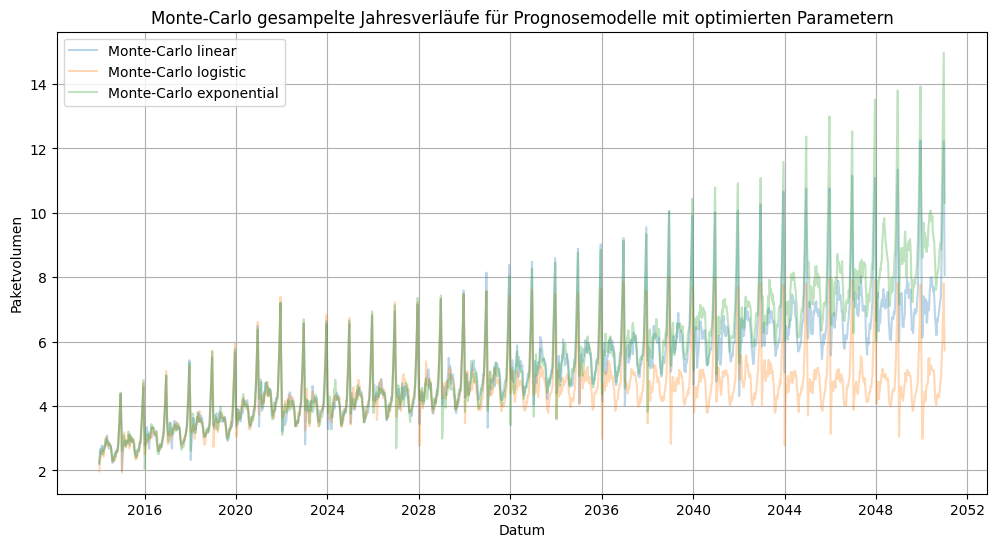

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.optimize import curve_fit

# Beispiel-Daten (müssen durch echte Daten ersetzt werden)
data = {
    "Year": np.array([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023,
                      2024, 2025, 2026, 2027, 2028]),
    "Value": np.array([2.780, 2.950, 3.160, 3.350, 3.520, 3.650, 4.050, 4.510, 4.150, 4.175,
                       4.200, 4.300, 4.420, 4.550, 4.680])
}

# Logistische Funktion definieren
def logistic_function(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

# Exponentielle Funktion definieren
def exponential_function(x, a, b):
    return a * np.exp(b * (x - x[0]))

# DataFrame erstellen und 2021 entfernen (Corona-Jahr)
df_known = pd.DataFrame(data)
df_known_filtered = df_known[df_known["Year"] != 2021]

# Lineares Modell mit statsmodels fitten
X = sm.add_constant(df_known_filtered["Year"])
model_sm = sm.OLS(df_known_filtered["Value"], X).fit()
X_future = sm.add_constant(np.arange(2029, 2051))
pred_summary = model_sm.get_prediction(X_future).summary_frame(alpha=0.05)

# Letzter bekannter Wert aus den Daten für 2028
last_known_value = df_known[df_known["Year"] == 2028]["Value"].values[0]

# Logistische Regression anpassen
popt_logistic, pcov_logistic = curve_fit(
    logistic_function, 
    df_known_filtered["Year"], 
    df_known_filtered["Value"], 
    p0=[df_known_filtered["Value"].max(), 0.1, 2030], 
    maxfev=10000
)
popt_exponential, _ = curve_fit(exponential_function, df_known_filtered["Year"], df_known_filtered["Value"], p0=[1, 0.05])

# Logistische und exponentielle Prognosen berechnen
years_future = np.arange(2029, 2051)
y_logistic_forecast = logistic_function(years_future, *popt_logistic)
y_exponential_forecast = exponential_function(years_future, *popt_exponential)

# Anpassen der Prognosen auf den letzten Wert von 2028
scale_logistic = last_known_value / y_logistic_forecast[0]
scale_exponential = last_known_value / y_exponential_forecast[0]

y_logistic_forecast *= scale_logistic
y_exponential_forecast *= scale_exponential

# Rücktransformation der Prognosen
# Konfidenzintervalle aus der Kovarianzmatrix berechnen
perr_logistic = np.sqrt(np.diag(pcov_logistic))
y_logistic_lower = logistic_function(years_future, *(popt_logistic - 1.96 * perr_logistic))
y_logistic_upper = logistic_function(years_future, *(popt_logistic + 1.96 * perr_logistic))

# Statsmodels für exponentielle Regression
df_known_filtered["log_value"] = np.log(df_known_filtered["Value"])
X_exponential = sm.add_constant(df_known_filtered["Year"])
model_exponential_sm = sm.OLS(df_known_filtered["log_value"], X_exponential).fit()
X_future_exponential = sm.add_constant(years_future)
pred_exponential_sm = model_exponential_sm.get_prediction(X_future_exponential).summary_frame(alpha=0.05)

# Rücktransformation der Prognosen
y_exponential_lower = np.exp(pred_exponential_sm["mean_ci_lower"])
y_exponential_upper = np.exp(pred_exponential_sm["mean_ci_upper"])

# Daten kombinieren (bis 2028 bekannt, danach Prognose mit Unsicherheiten)
combined_years = np.concatenate([df_known["Year"], years_future])
combined_linear = np.concatenate([df_known["Value"], pred_summary["mean"]])
combined_logistic = np.concatenate([df_known["Value"], y_logistic_forecast])
combined_exponential = np.concatenate([df_known["Value"], y_exponential_forecast])

# Richtige Unsicherheiten für jedes Modell nutzen
combined_ci_lower_linear = np.concatenate([df_known["Value"], pred_summary["mean_ci_lower"]])
combined_ci_upper_linear = np.concatenate([df_known["Value"], pred_summary["mean_ci_upper"]])

combined_ci_lower_logistic = np.concatenate([df_known["Value"], y_logistic_lower])
combined_ci_upper_logistic = np.concatenate([df_known["Value"], y_logistic_upper])

combined_ci_lower_exponential = np.concatenate([df_known["Value"], y_exponential_lower])
combined_ci_upper_exponential = np.concatenate([df_known["Value"], y_exponential_upper])

# Alles in ein DataFrame packen
df_combined_ci = pd.DataFrame({
    "year": combined_years,
    "linear": combined_linear,
    "logistic": combined_logistic,
    "exponential": combined_exponential,
    "ci_lower_linear": combined_ci_lower_linear,
    "ci_upper_linear": combined_ci_upper_linear,
    "ci_lower_logistic": combined_ci_lower_logistic,
    "ci_upper_logistic": combined_ci_upper_logistic,
    "ci_lower_exponential": combined_ci_lower_exponential,
    "ci_upper_exponential": combined_ci_upper_exponential
})

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# === 📌 Optimierte Parameter aus GA ===
alpha_opt = 0.576
noise_opt = 0.014
xmas_opt = 1.266
xmas_reduction_opt = 0.749
xmas_start_opt = 45
xmas_end_opt = 50

# Typischer Jahresverlauf als Basis
anzahl_wochen = len(df_ci)
years_future = np.arange(2029, 2051)

# Typischer Jahresverlauf und Unsicherheiten
typischer_mean = df_ci["mean"].values
typischer_lower = df_ci["ci_lower"].values
typischer_upper = df_ci["ci_upper"].values
anzahl_wochen = len(typischer_mean)

# Neuer DataFrame für die Monte-Carlo gesampelten Prognosen
weekly_forecast_ci = []

for _, row in df_combined_ci.iterrows():
    year = int(row["year"])

    # Wochenweise Zeitstempel generieren (Montags)
    weeks = pd.date_range(start=f"{year}-01-04", periods=anzahl_wochen, freq='W-MON')

    # DataFrame für dieses Jahr initialisieren
    temp_df = pd.DataFrame({"Datum": weeks, "Jahr": year})

    for model_name, model_value in zip(["linear", "logistic", "exponential"], 
                                       [row["linear"], row["logistic"], row["exponential"]]):

        # Monte-Carlo Sampling für den Jahresverlauf
        sampled_trajectory = np.zeros(anzahl_wochen)
        sampled_trajectory[0] = np.random.normal(df_ci["mean"].iloc[0], df_ci["std"].iloc[0])
        
        for t in range(1, anzahl_wochen):
            week_num = df_ci.index[t].week

            # Weihnachts-Boost und Reduktion
            if xmas_start_opt <= week_num <= xmas_end_opt:
                alpha = alpha_opt + 0.2
                scale_factor = xmas_opt
            elif week_num > xmas_end_opt:
                alpha = alpha_opt
                scale_factor = xmas_reduction_opt
            else:
                alpha = alpha_opt
                scale_factor = 1.0
            
            # Autoregressives Monte-Carlo Sampling
            sampled_trajectory[t] = (
                alpha * sampled_trajectory[t-1] +
                (1 - alpha) * np.random.normal(df_ci["mean"].iloc[t] * scale_factor, df_ci["std"].iloc[t]) +
                np.random.normal(0, max(0.001, noise_opt))
            )
        
        # Skalierung mit dem Modellwert für das Jahr
        sampled_trajectory *= model_value

        # === 📌 Skalierung mit typischem Jahresverlauf beibehalten ===
        temp_df[f"{model_name}_Prognose"] = sampled_trajectory
        temp_df[f"{model_name}_CI_Lower"] = typischer_lower * row[f"ci_lower_{model_name}"]
        temp_df[f"{model_name}_CI_Upper"] = typischer_upper * row[f"ci_upper_{model_name}"]
        temp_df[f"{model_name}_Mean_Typical"] = typischer_mean * row[model_name]  # 🔥 Typischer Verlauf bleibt

    # Speichern des kombinierten DataFrames für dieses Jahr
    weekly_forecast_ci.append(temp_df)

# Alles zusammenführen
weekly_forecast_ci_df = pd.concat(weekly_forecast_ci).reset_index(drop=True)

# === 📈 Visualisierung der gesampelten Jahresverläufe ===
plt.figure(figsize=(12, 6))

for model_name in ["linear", "logistic", "exponential"]:
    subset = weekly_forecast_ci_df[["Datum", f"{model_name}_Prognose"]].dropna()
    plt.plot(subset["Datum"], subset[f"{model_name}_Prognose"], alpha=0.3, label=f"Monte-Carlo {model_name}")

plt.xlabel("Datum")
plt.ylabel("Paketvolumen")
plt.title("Monte-Carlo gesampelte Jahresverläufe für Prognosemodelle mit optimierten Parametern")
plt.legend()
plt.grid(True)
plt.show()


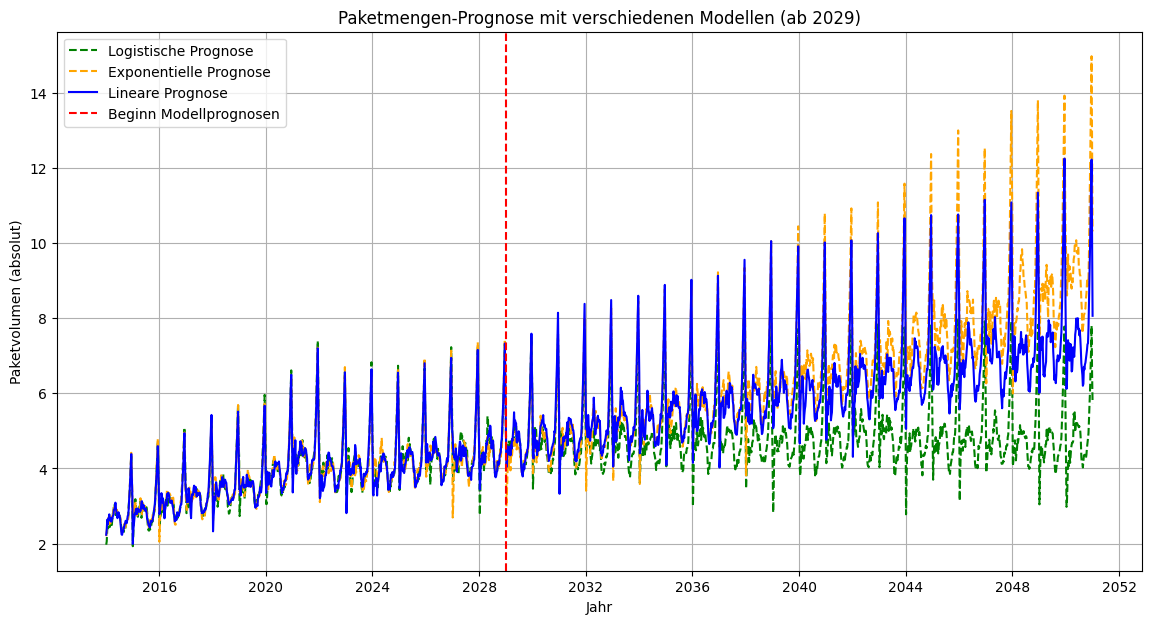

In [109]:
plt.figure(figsize=(14, 7))

# Plot für logistische Prognose
plt.plot(weekly_forecast_ci_df["Datum"], weekly_forecast_ci_df["logistic_Prognose"], color="green", linestyle="--", label="Logistische Prognose")

# Plot für exponentielle Prognose
plt.plot(weekly_forecast_ci_df["Datum"], weekly_forecast_ci_df["exponential_Prognose"], color="orange", linestyle="--", label="Exponentielle Prognose")

# Plot für lineare Prognose
plt.plot(weekly_forecast_ci_df["Datum"], weekly_forecast_ci_df["linear_Prognose"], color="blue", label="Lineare Prognose")


# Markiere den Startpunkt für die Prognosen (2028)
plt.axvline(pd.Timestamp("2028-12-31"), color="red", linestyle="--", label="Beginn Modellprognosen")

plt.xlabel("Jahr")
plt.ylabel("Paketvolumen (absolut)")
plt.title("Paketmengen-Prognose mit verschiedenen Modellen (ab 2029)")
plt.legend()
plt.grid(True)
plt.show()


In [115]:
weekly_forecast_ci_df

,Datum,Jahr,linear_Prognose,linear_CI_Lower,linear_CI_Upper,linear_Mean_Typical,logistic_Prognose,logistic_CI_Lower,logistic_CI_Upper,logistic_Mean_Typical,exponential_Prognose,exponential_CI_Lower,exponential_CI_Upper,exponential_Mean_Typical
0,2014-01-06,2014,2.234043,1.589793,2.855768,2.222781,1.969323,1.589793,2.855768,2.222781,2.195225,1.589793,2.855768,2.222781
1,2014-01-13,2014,2.368549,2.102238,3.014373,2.558306,2.059363,2.102238,3.014373,2.558306,2.342934,2.102238,3.014373,2.558306
2,2014-01-20,2014,2.633590,2.407968,3.132274,2.770121,2.379648,2.407968,3.132274,2.770121,2.431726,2.407968,3.132274,2.770121
3,2014-01-27,2014,2.509896,2.263455,3.252489,2.757972,2.405967,2.263455,3.252489,2.757972,2.626790,2.263455,3.252489,2.757972
4,2014-02-03,2014,2.662511,2.143286,3.286302,2.714794,2.413367,2.143286,3.286302,2.714794,2.680529,2.143286,3.286302,2.714794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1919,2050-12-05,2050,10.600252,9.522291,11.293100,10.395318,6.555596,6.085178,7.222495,6.745250,12.640594,11.795796,17.273194,12.744957
1920,2050-12-12,2050,11.556904,10.259155,12.440885,11.328021,7.128006,6.556068,7.956560,7.350456,13.810568,12.708591,19.028772,13.888476
1921,2050-12-19,2050,12.218137,10.718126,13.253570,11.954762,7.799392,6.849371,8.476312,7.757132,14.970869,13.277144,20.271802,14.656879
1922,2050-12-26,2050,10.119081,8.398864,12.389790,10.306564,6.541256,5.367257,7.923883,6.687660,12.388557,10.404143,18.950621,12.636142


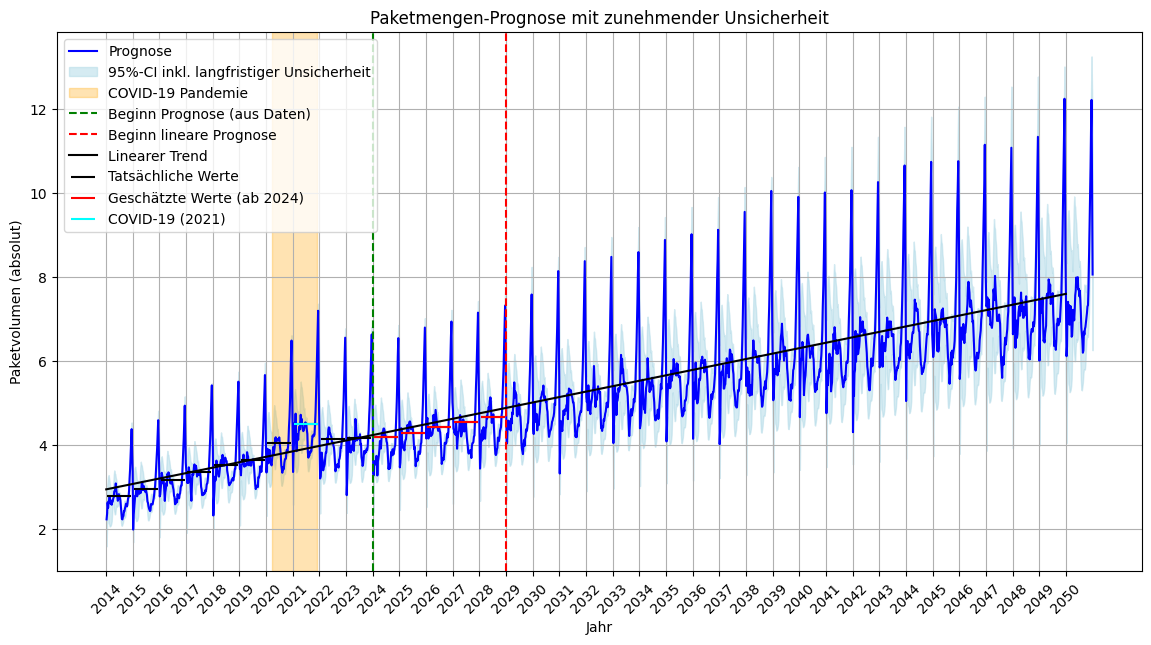

In [125]:
plt.figure(figsize=(14, 7))

# Prognose plotten
plt.plot(weekly_forecast_ci_df["Datum"], weekly_forecast_ci_df["linear_Prognose"], color="blue", label="Prognose")
# plt.plot(weekly_forecast_ci_df["Datum"], weekly_forecast_ci_df["linear_Mean_Typical"], color="black", label="Prognose", linewidth=0.5)

# erweitertes Konfidenzintervall
plt.fill_between(weekly_forecast_ci_df["Datum"],
                 weekly_forecast_ci_df["linear_CI_Lower"],
                 weekly_forecast_ci_df["linear_CI_Upper"],
                 color="lightblue", alpha=0.5, label="95%-CI inkl. langfristiger Unsicherheit")

# plt.scatter(df["Year"], df["Relative_Value"], color="black", label="Tatsächliche Werte")
# plt.scatter(df_estimated["Year"], df_estimated["Relative_Value"], color="red", label="Geschätzte Werte (ab 2024)")
# plt.scatter(df[df.Year == 2021]["Year"], df[df.Year == 2021]["Relative_Value"], color="pink", label="COVID-19 (2021)")

# Prognoselinien von 2014 bis 2050 mit Gütemaßen in Legende


# Corona-Zeitraum (25. März 2020 - 25. November 2021) farblich hervorheben
plt.axvspan(pd.Timestamp("2020-03-25"), pd.Timestamp("2021-11-25"), color="orange", alpha=0.3, label="COVID-19 Pandemie")

plt.axvline(pd.Timestamp("2023-12-31"), color="green", linestyle="--", label="Beginn Prognose (aus Daten)")
plt.axvline(pd.Timestamp("2028-12-31"), color="red", linestyle="--", label="Beginn lineare Prognose")

plt.plot(pd.to_datetime([f"{year}-01-01" for year in years_forecast]), y_linear_forecast_data, linestyle="-", color="black", label="Linearer Trend")

# Umwandlung der Jahreswerte in Datetime für die Scatter-Plots
scatter_years = pd.to_datetime([f"{year}-07-01" for year in df["Year"]])
scatter_estimated_years = pd.to_datetime([f"{year}-07-01" for year in df_estimated["Year"]])
scatter_covid_years = pd.to_datetime([f"{year}-07-01" for year in df[df.Year == 2021]["Year"]])
# Scatter-Plots mit umgewandelten Datetime-Werten

plt.scatter(scatter_years, df["Value"], color="black", label="Tatsächliche Werte", zorder=10, marker="_", s=300)
plt.scatter(scatter_estimated_years, df_estimated["Value"], color="red", label="Geschätzte Werte (ab 2024)", zorder=10, marker="_", s=300)
plt.scatter(scatter_covid_years, df[df.Year == 2021]["Value"], color="cyan", label="COVID-19 (2021)", zorder=10, marker="_", s=300)

plt.xlabel("Jahr")
plt.ylabel("Paketvolumen (absolut)")
plt.title("Paketmengen-Prognose mit zunehmender Unsicherheit")

# # X-Achsen-Limit setzen (von 2024 bis 2030)
# plt.xlim(pd.Timestamp("2024-01-01"), pd.Timestamp("2030-12-31"))
# # Jährliche Ticks von 2024 bis 2030 setzen
# years_range = np.arange(2024, 2031)
# plt.xticks(pd.to_datetime([f"{year}-01-01" for year in years_range]), years_range, rotation=45)


# Jährliche Ticks von 2014 bis 2050 setzen
years_range = np.arange(2014, 2051)
plt.xticks(pd.to_datetime([f"{year}-01-01" for year in years_range]), years_range, rotation=45)


plt.legend()
plt.grid(True)
plt.show()


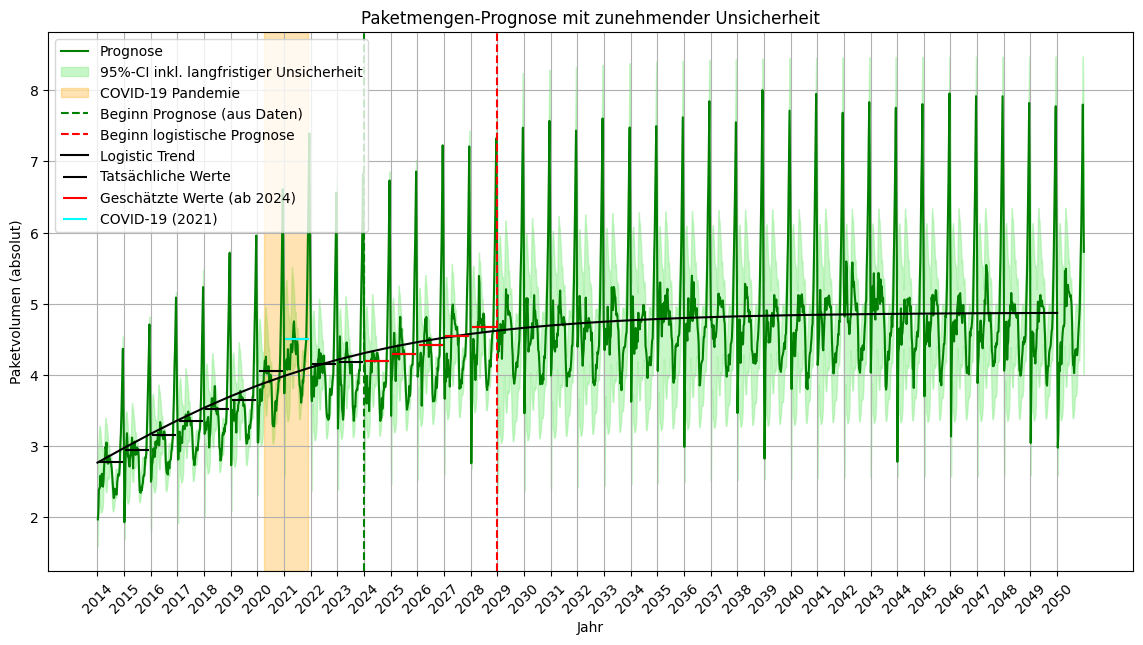

In [113]:
plt.figure(figsize=(14, 7))

# Prognose plotten
plt.plot(weekly_forecast_ci_df["Datum"], weekly_forecast_ci_df["logistic_Prognose"], color="green", label="Prognose")

# erweitertes Konfidenzintervall
plt.fill_between(weekly_forecast_ci_df["Datum"],
                 weekly_forecast_ci_df["logistic_CI_Lower"],
                 weekly_forecast_ci_df["logistic_CI_Upper"],
                 color="lightgreen", alpha=0.5, label="95%-CI inkl. langfristiger Unsicherheit")

# Prognoselinien von 2014 bis 2050 mit Gütemaßen in Legende

# Corona-Zeitraum (25. März 2020 - 25. November 2021) farblich hervorheben
plt.axvspan(pd.Timestamp("2020-03-25"), pd.Timestamp("2021-11-25"), color="orange", alpha=0.3, label="COVID-19 Pandemie")

plt.axvline(pd.Timestamp("2023-12-31"), color="green", linestyle="--", label="Beginn Prognose (aus Daten)")
plt.axvline(pd.Timestamp("2028-12-31"), color="red", linestyle="--", label="Beginn logistische Prognose")

plt.plot(pd.to_datetime([f"{year}-01-01" for year in years_forecast]), y_logistic_forecast_data, linestyle="-", color="black", label="Logistic Trend")

# Umwandlung der Jahreswerte in Datetime für die Scatter-Plots
scatter_years = pd.to_datetime([f"{year}-07-01" for year in df["Year"]])
scatter_estimated_years = pd.to_datetime([f"{year}-07-01" for year in df_estimated["Year"]])
scatter_covid_years = pd.to_datetime([f"{year}-07-01" for year in df[df.Year == 2021]["Year"]])
# Scatter-Plots mit umgewandelten Datetime-Werten

plt.scatter(scatter_years, df["Value"], color="black", label="Tatsächliche Werte", zorder=10, marker="_", s=300)
plt.scatter(scatter_estimated_years, df_estimated["Value"], color="red", label="Geschätzte Werte (ab 2024)", zorder=10, marker="_", s=300)
plt.scatter(scatter_covid_years, df[df.Year == 2021]["Value"], color="cyan", label="COVID-19 (2021)", zorder=10, marker="_", s=300)

plt.xlabel("Jahr")
plt.ylabel("Paketvolumen (absolut)")
plt.title("Paketmengen-Prognose mit zunehmender Unsicherheit")
plt.legend()
plt.grid(True)


# Jährliche Ticks von 2014 bis 2050 setzen
years_range = np.arange(2014, 2051)
plt.xticks(pd.to_datetime([f"{year}-01-01" for year in years_range]), years_range, rotation=45)

plt.show()


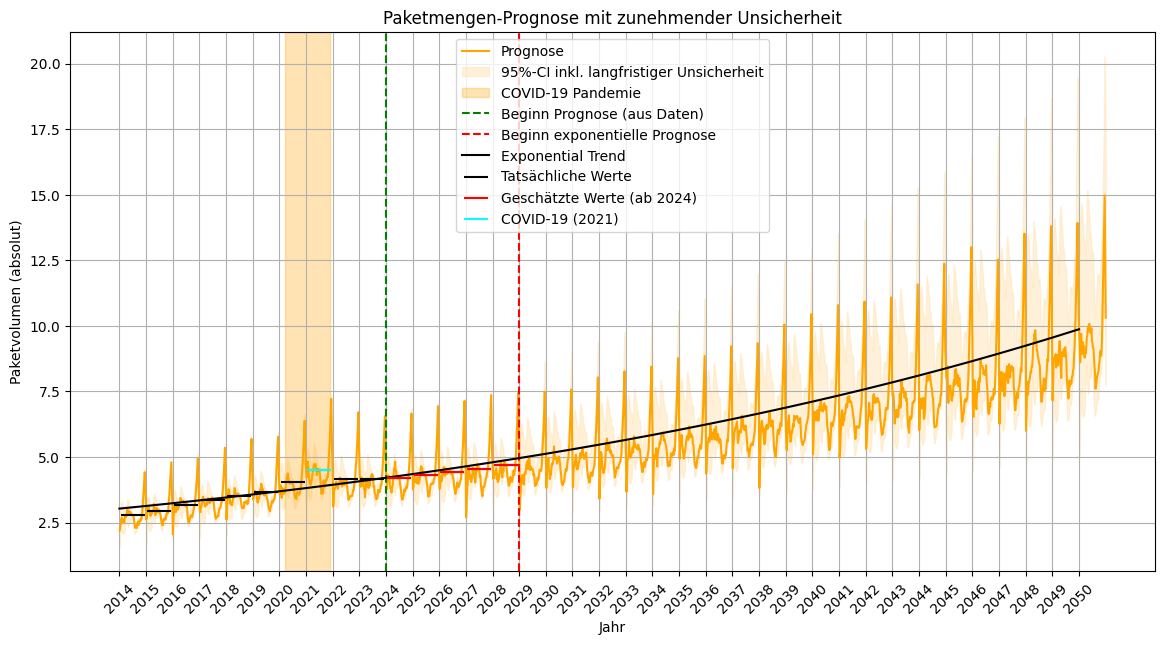

In [114]:
plt.figure(figsize=(14, 7))

# Prognose plotten
plt.plot(weekly_forecast_ci_df["Datum"], weekly_forecast_ci_df["exponential_Prognose"], color="orange", label="Prognose")

# erweitertes Konfidenzintervall
plt.fill_between(weekly_forecast_ci_df["Datum"],
                 weekly_forecast_ci_df["exponential_CI_Lower"],
                 weekly_forecast_ci_df["exponential_CI_Upper"],
                 color="moccasin", alpha=0.5, label="95%-CI inkl. langfristiger Unsicherheit")

# Corona-Zeitraum (25. März 2020 - 25. November 2021) farblich hervorheben
plt.axvspan(pd.Timestamp("2020-03-25"), pd.Timestamp("2021-11-25"), color="orange", alpha=0.3, label="COVID-19 Pandemie")

plt.axvline(pd.Timestamp("2023-12-31"), color="green", linestyle="--", label="Beginn Prognose (aus Daten)")
plt.axvline(pd.Timestamp("2028-12-31"), color="red", linestyle="--", label="Beginn exponentielle Prognose")

plt.plot(pd.to_datetime([f"{year}-01-01" for year in years_forecast]), y_exponential_forecast_data, linestyle="-", color="black", label="Exponential Trend")

# Umwandlung der Jahreswerte in Datetime für die Scatter-Plots
scatter_years = pd.to_datetime([f"{year}-07-01" for year in df["Year"]])
scatter_estimated_years = pd.to_datetime([f"{year}-07-01" for year in df_estimated["Year"]])
scatter_covid_years = pd.to_datetime([f"{year}-07-01" for year in df[df.Year == 2021]["Year"]])
# Scatter-Plots mit umgewandelten Datetime-Werten

plt.scatter(scatter_years, df["Value"], color="black", label="Tatsächliche Werte", zorder=10, marker="_", s=300)
plt.scatter(scatter_estimated_years, df_estimated["Value"], color="red", label="Geschätzte Werte (ab 2024)", zorder=10, marker="_", s=300)
plt.scatter(scatter_covid_years, df[df.Year == 2021]["Value"], color="cyan", label="COVID-19 (2021)", zorder=10, marker="_", s=300)

plt.xlabel("Jahr")
plt.ylabel("Paketvolumen (absolut)")
plt.title("Paketmengen-Prognose mit zunehmender Unsicherheit")
plt.legend()
plt.grid(True)

# Jährliche Ticks von 2014 bis 2050 setzen
years_range = np.arange(2014, 2051)
plt.xticks(pd.to_datetime([f"{year}-01-01" for year in years_range]), years_range, rotation=45)

plt.show()


In [138]:
import pandas as pd

# Spalten für die Relativierung
prognose_columns = ["linear_Prognose", "logistic_Prognose", "exponential_Prognose"]

# Mittelwerte für 2021 berechnen (jeweils für die eigene Zeitreihe)
mean_2021 = weekly_forecast_ci_df.loc[
    weekly_forecast_ci_df["Jahr"] == 2021, prognose_columns
].mean(numeric_only=True)

# Neuen DataFrame mit relativierten Werten erstellen (inklusive Datum, Jahr und Prognosen)
weekly_forecast_relative_df = weekly_forecast_ci_df[["Datum", "Jahr"] + prognose_columns].copy()

# Werte relativ zur eigenen Zeitreihe von 2021 setzen
for col in prognose_columns:
    base_value = mean_2021.get(col, None)
    if base_value and base_value != 0:
        weekly_forecast_relative_df[col] /= base_value

weekly_forecast_relative_df


,Datum,Jahr,linear_Prognose,logistic_Prognose,exponential_Prognose
0,2014-01-06,2014,0.501605,0.441320,0.489425
1,2014-01-13,2014,0.531806,0.461498,0.522357
2,2014-01-20,2014,0.591315,0.533273,0.542153
3,2014-01-27,2014,0.563542,0.539171,0.585642
4,2014-02-03,2014,0.597808,0.540829,0.597623
...,...,...,...,...,...
1919,2050-12-05,2050,2.380054,1.469091,2.818218
1920,2050-12-12,2050,2.594849,1.597366,3.079063
1921,2050-12-19,2050,2.743314,1.747822,3.337752
1922,2050-12-26,2050,2.272017,1.465877,2.762026


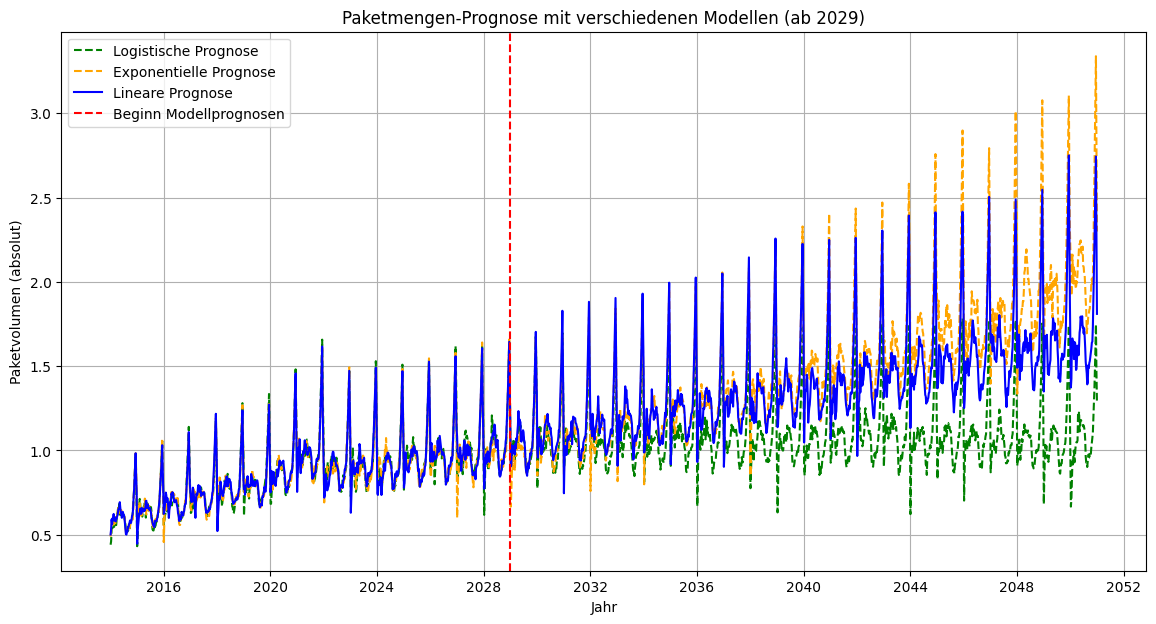

In [139]:
plt.figure(figsize=(14, 7))

# Plot für logistische Prognose
plt.plot(weekly_forecast_relative_df["Datum"], weekly_forecast_relative_df["logistic_Prognose"], color="green", linestyle="--", label="Logistische Prognose")

# Plot für exponentielle Prognose
plt.plot(weekly_forecast_relative_df["Datum"], weekly_forecast_relative_df["exponential_Prognose"], color="orange", linestyle="--", label="Exponentielle Prognose")

# Plot für lineare Prognose
plt.plot(weekly_forecast_relative_df["Datum"], weekly_forecast_relative_df["linear_Prognose"], color="blue", label="Lineare Prognose")


# Markiere den Startpunkt für die Prognosen (2028)
plt.axvline(pd.Timestamp("2028-12-31"), color="red", linestyle="--", label="Beginn Modellprognosen")

plt.xlabel("Jahr")
plt.ylabel("Paketvolumen (absolut)")
plt.title("Paketmengen-Prognose mit verschiedenen Modellen (ab 2029)")
plt.legend()
plt.grid(True)
plt.show()


In [145]:
# Marktanteile der verschiedenen Paketdienste
market_shares = {
    'dhl': 0.40,
    'hermes': 0.14,
    'ups': 0.12 * 1.2,
    'amazon': 0.10,
    'dpd': 0.10 * 1.2,
    'gls': 0.08 * 1.2,
    'fedex': 0.06 * 1.2
}

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Gegebene Daten
data_2022 = {
    "Jahr": 2022,
    "DHL": 49,
    "Hermes": 13,
    "UPS": 12,
    "DPD": 11,
    "GLS": 8,
    "FedEx/TNT": 6
}

growth = {
    "DHL": 6,
    "Hermes": -1.5,
    "UPS": 0.2,
    "DPD": -0.5,
    "GLS": 1,
    "FedEx/TNT": -0.2,
}

# Marktanteile 2016 berechnen
data_2016 = {"Jahr": 2016}
for k, v in growth.items():
    data_2016[k] = data_2022[k] - v

# DataFrame initialisieren
years = list(range(2014, 2051))
df_market = pd.DataFrame({"Jahr": years})

# Jährliche Veränderung berechnen
years_diff = 2022 - 2016
annual_change = {k: growth[k] / years_diff for k in growth}

# Fortschreibung und Rückrechnung mit Dämpfung
for k in data_2022.keys():
    if k == "Jahr":
        continue
    values = []
    for year in years:
        if year < 2016:
            value = data_2016[k] - annual_change[k] * (2016 - year)
        elif year <= 2022:
            value = data_2016[k] + (data_2022[k] - data_2016[k]) * (year - 2016) / (2022 - 2016)
        else:
            delta_years = year - 2022
            damping = 1 / np.sqrt(delta_years + 1)
            value = values[-1] + annual_change.get(k, 0) * damping * 2.25
        values.append(value)
    df_market[k] = values

# Normalisieren auf 100 %
categories = ["DHL", "Hermes", "UPS", "DPD", "GLS", "FedEx/TNT"]
colors = ["blue", "darkblue", "gray", "red", "green", "gold"]

df_market_sum = df_market[categories].sum(axis=1)
df_market[categories] = df_market[categories].div(df_market_sum, axis=0) * 100

# Plot
plt.figure(figsize=(12, 6))
plt.stackplot(df_market["Jahr"], [df_market[cat] for cat in categories], labels=categories, colors=colors, alpha=0.7)
plt.xlabel("Jahr")
plt.ylabel("Marktanteil (in %)")
plt.title("Prognose der Marktanteile der Paketdienste in Deutschland (2014–2050)")
plt.legend(loc="upper left")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Gegebenes Datenvolumen (Gesamtmenge in Deutschland, in Milliarden)
data = {
    "Year": np.array([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023,
                      2024, 2025, 2026, 2027, 2028]),
    "Value": np.array([2.780, 2.950, 3.160, 3.350, 3.520, 3.650, 4.050, 4.510, 4.150, 4.175,
                       4.200, 4.300, 4.420, 4.550, 4.680])  # In Milliarden Pakete
}
df_total = pd.DataFrame(data)

# Amazon-Daten (Pakete in Millionen)
amazon_data = {
    "Year": [2017, 2020],
    "In Eigenregie": [22, 405],  # In Millionen Pakete
}

# Umrechnung der Gesamtpaketmenge auf Millionen
df_total["Value"] *= 1000  # Milliarden -> Millionen

df_amazon = pd.DataFrame(amazon_data)

# Zusammenführen der Daten
df_merged = df_total.merge(df_amazon, on="Year", how="inner")

# Berechnung des Anteils der Amazon-Eigenregie-Pakete am Gesamtmarkt
df_merged["Amazon Anteil (%)"] = (df_merged["In Eigenregie"] / df_merged["Value"]) * 100

# Lineare Regression von 2017 bis 2020
x_linear = df_merged["Year"].values.reshape(-1, 1)
y_linear = df_merged["Amazon Anteil (%)"].values

model = LinearRegression()
model.fit(x_linear, y_linear)

# Prognosejahre
future_years = np.arange(2014, 2051)

# Prognose: bis 2023 linear, danach konstant
predicted_values = []
for year in future_years:
    if year <= 2023:
        if year < 2017:
            pred = 0
        else:
            pred = model.predict(np.array([[year]]))[0]
    else:
        pred = model.predict(np.array([[2023]]))[0]  # Konstanter Wert ab 2023
    predicted_values.append(pred)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(future_years, predicted_values, label="Prognose Amazon Eigenregie (linear + konstant)", color="green")
plt.scatter(x_linear.flatten(), y_linear, label="Beobachtete Werte", color="red")

plt.xlabel("Jahr")
plt.ylabel("Marktanteil Amazon Eigenregie (%)")
plt.title("Amazon Eigenregie-Anteil am Paketmarkt (Prognose: linear bis 2023, dann konstant)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Fehlende Variablen erneut definieren
import numpy as np
import matplotlib.pyplot as plt

years_future = np.arange(2014, 2051)

# Gegebene Amazon-Daten (Marktanteil in %)
amazon_years = np.array([2017, 2020, 2022])
amazon_shares = np.array([22 / 4050 * 100, 10, 20])

# Sigmoid-Funktion erneut definieren (wegen vorherigem Fehler)
def sigmoid(x, L, x0, k):
    return L / (1 + np.exp(-k * (x - x0)))

# Manuelle Parameterwahl für die Sigmoid-Funktion
L = 21  # Maximale Sättigung in %
x0 = 2020  # Wendepunkt des Wachstums (Peak-Wachstumsjahr)
k = 1.35  # Steigungsfaktor (höher = steilerer Anstieg)

# Berechnung der Amazon-Prognose mit der Sigmoid-Funktion
amazon_predicted_sigmoid = sigmoid(years_future, L, x0, k)

# Plot mit neuer Sigmoid-Kurve
plt.figure(figsize=(10, 5))
plt.plot(years_future, amazon_predicted_sigmoid, label="Sigmoid-Approximation (geschätzt)", color="blue")
plt.scatter(amazon_years, amazon_shares, label="Beobachtete Werte", color="red")
plt.axhline(y=L, color="gray", linestyle="dashed", label=f"Sättigung bei {L:.1f}%")

plt.xlabel("Jahr")
plt.ylabel("Marktanteil Amazon Eigenregie (%)")
plt.title("Sigmoid-Approximation des Amazon-Eigenregie-Anteils am Paketmarkt")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Beispielhafter DataFrame df_market vorbereiten (falls nicht vorhanden)
years = list(range(2014, 2051))

# Sigmoid-Funktion
def sigmoid(x, L, x0, k):
    return L / (1 + np.exp(-k * (x - x0)))

# Parameter für Amazon
L = 21
x0 = 2020
k = 1.35

# Amazon-Anteil mit Sigmoid-Kurve berechnen und in DataFrame einfügen
df_market["Amazon"] = sigmoid(df_market["Jahr"], L, x0, k)

# Alle Anbieter inkl. Amazon
all_categories = ["DHL", "Hermes", "UPS", "DPD", "GLS", "FedEx/TNT", "Amazon"]

# Marktanteile auf 100 % normieren
df_market_sum = df_market[all_categories].sum(axis=1)
df_market[all_categories] = df_market[all_categories].div(df_market_sum, axis=0) * 100

# Neue Farben für den Plot inkl. Amazon
colors_extended = ["blue", "darkblue", "gray", "red", "green", "gold", "orange"]

# Gestapeltes Flächendiagramm mit Amazon
plt.figure(figsize=(12, 6))
plt.stackplot(df_market["Jahr"], [df_market[cat] for cat in all_categories], 
              labels=all_categories, colors=colors_extended, alpha=0.8)
plt.xlabel("Jahr")
plt.ylabel("Marktanteil (in %)")
plt.title("Prognose der Marktanteile der Paketdienste in Deutschland inkl. Amazon (2014–2050)")
plt.legend(loc="upper left")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

df_market

In [ ]:

# Optionale Unsicherheitskomponente mit individuellen Schwankungen pro Anbieter aktivieren
unsicherheit_aktiv = True  # Setze auf False, wenn keine Unsicherheit gewünscht ist
df_market_changed = df_market.copy()

if unsicherheit_aktiv:
    np.random.seed(42)
    years_future = df_market_changed[df_market_changed["Jahr"] >= 2025]["Jahr"].values
    for cat in all_categories:
        noise = np.random.normal(0, 0.02, len(years_future))
        smooth_variation = np.cumsum(noise)
        smooth_variation = pd.Series(smooth_variation).rolling(window=3, center=True, min_periods=1).mean()
        uncertainty_factor = 1 + smooth_variation.values
        df_market_changed.loc[df_market_changed["Jahr"] >= 2025, cat] *= uncertainty_factor
    df_market_sum = df_market_changed[all_categories].sum(axis=1)
    df_market_changed[all_categories] = df_market_changed[all_categories].div(df_market_sum, axis=0) * 100

# Farben für den Plot
colors_extended = ["blue", "darkblue", "gray", "red", "green", "gold", "orange"]

# Gestapeltes Flächendiagramm mit Unsicherheitsmodellierung pro Anbieter
plt.figure(figsize=(12, 6))
plt.stackplot(df_market_changed["Jahr"], [df_market_changed[cat] for cat in all_categories], 
              labels=all_categories, colors=colors_extended, alpha=0.8)
plt.xlabel("Jahr")
plt.ylabel("Marktanteil (in %)")
plt.title("Prognose der Marktanteile der Paketdienste in Deutschland inkl. Amazon (2014–2050) mit individueller Unsicherheit")
plt.legend(loc="upper left")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [143]:
print("Read Data")
folder = "Verteilung-Oskar/"

matsim_network_xml_file = "multimodalNetwork.xml"
dhl_strassen_file = "dhl/dhl2streets_2021.shp"
hermes_file = "hermes/Hermes_PLZ-Menge_2019-2021.csv"

matsim_gdf = matsim.read_network(folder+matsim_network_xml_file).as_geo()

dhl_streets_gdf = gpd.read_file(folder+dhl_strassen_file, encoding='UTF-8')
dhl_streets_gdf = dhl_streets_gdf.to_crs(crs)
dhl_streets_gdf = dhl_streets_gdf.rename(columns={'tagesschni': 'dhl_tag'})

hermes_df = pd.read_csv(folder+hermes_file, encoding='utf-8', sep=';', thousands='.')
hermes_df['hermes_tag'] = round(( hermes_df['2020'] + (8/12)*(hermes_df['2021']-hermes_df['2020']) ) / 26) # warum -2020?? (warum 26?-> auf Tage)

Read Data


In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import random
import logging
# Optional: For parallel processing, you can uncomment the following lines
# from joblib import Parallel, delayed

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def _distribute_changes(df: pd.DataFrame, column: str, multiplier: float) -> None:
    """
    Adjusts the values in the given column of the DataFrame 'df' proportionally using a multiplier.
    Prevents division by zero and distributes rounding differences based on the largest fractional parts.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the data to adjust.
    column : str
        Name of the column to adjust.
    multiplier : float
        Scaling factor. For example, multiplier > 1 increases values, while multiplier < 1 decreases values.
    """
    total_value = df[column].sum()
    if total_value == 0:
        logging.warning(f"Total value for column '{column}' is zero. Skipping adjustment.")
        return

    added = round(total_value * (multiplier))
    proportional_addition = df[column] / total_value * added
    integer_part = np.floor(proportional_addition).astype(int)
    fractional_part = proportional_addition - integer_part
    rounding_adjustment = added - integer_part.sum()
    if rounding_adjustment != 0:
        fractional_indices = np.argsort(-fractional_part)
        integer_part[fractional_indices[:rounding_adjustment]] += 1
    df[column] += integer_part

def _process_postal_code(plz, row, carriers, dhl_streets_gdf):
    """
    Distributes the packages for a given postal code (plz) across the road segments.
    
    Uses np.random.multinomial to distribute, for each carrier (e.g. 'hermes', 'ups', etc.),
    the packages proportional to the DHL values over the segments.
    
    Parameters
    ----------
    plz : str or int
        The postal code (plz).
    row : pd.Series
        Aggregated values for the postal code (including columns like 'dhl_tag', 'hermes_tag', etc.).
    carriers : list of str
        List of carrier names, e.g., ['hermes', 'ups', 'amazon', 'dpd', 'gls', 'fedex'].
    dhl_streets_gdf : gpd.GeoDataFrame
        GeoDataFrame containing road segments with at least the columns ['plz', 'dhl_tag', 'name', 'geometry'].
    
    Returns
    -------
    records : list
        A list of records for each segment with the distribution:
        [street_name, plz, geometry, dhl_tag, hermes_tag, ups_tag, ...]
    """
    # Filter the road segments for the given postal code (plz)
    segments_df = dhl_streets_gdf[dhl_streets_gdf['plz'] == plz].copy()
    if segments_df.empty:
        return []
    
    # Reset index for position-based operations
    segments_df = segments_df.reset_index(drop=True)
    weights = segments_df['dhl_tag'].values + 1  # Avoid zero weights
    weights_sum = weights.sum()
    pvals = weights / weights_sum if weights_sum > 0 else np.full_like(weights, 1/len(weights))
    
    # Compute the distribution for each carrier using np.random.multinomial
    carrier_counts = {}
    for carrier in carriers:
        col_name = f"{carrier}_tag"
        n = int(row[col_name])
        if n > 0:
            carrier_counts[carrier] = np.random.multinomial(n, pvals)
        else:
            carrier_counts[carrier] = np.zeros(len(segments_df), dtype=int)
    
    # Create a record for each segment with the distributions
    records = []
    for i, seg in segments_df.iterrows():
        # Use the 'name' column if available, otherwise use the index as the name
        street_name = seg.get('name', str(i))
        record = [
            street_name,
            plz,                # Keep the input postal code as 'plz'
            seg['geometry'],
            seg['dhl_tag']
        ]
        for carrier in carriers:
            record.append(int(carrier_counts[carrier][i]))
        records.append(record)
    return records

def distribute_market_data(market_shares: dict, multiplier: float, crs) -> gpd.GeoDataFrame:
    """
    Distributes the market data of package carriers across road segments.
    
    Parameters
    ----------
    market_shares : dict
        Dictionary with market shares, e.g., {'dhl': 0.3, 'hermes': 0.2, 'ups': 0.1, 'amazon': 0.15,
        'dpd': 0.1, 'gls': 0.1, 'fedex': 0.05}.
    multiplier : float
        Scaling factor for the 'hermes_tag' and 'dhl_tag' values.
        (multiplier > 1 increases, multiplier < 1 decreases the values).
    crs : dict or str
        Coordinate reference system for the returned GeoDataFrame.
    
    Global Dependencies
    -------------------
    - dhl_streets_gdf : gpd.GeoDataFrame
        GeoDataFrame containing road segments with at least the columns ['plz', 'dhl_tag', 'name', 'geometry'].
    - hermes_df : pd.DataFrame or gpd.GeoDataFrame
        DataFrame containing Hermes data with at least the columns ['PLZ', 'hermes_tag'].
    
    Returns
    -------
    gpd.GeoDataFrame
        GeoDataFrame with the columns:
        ['street_name', 'plz', 'geometry', 'dhl_tag', 'hermes_tag', 'ups_tag',
         'amazon_tag', 'dpd_tag', 'gls_tag', 'fedex_tag'].
    """
    # 1) Proportionally adjust values for DHL and Hermes
    _distribute_changes(hermes_df, 'hermes_tag', multiplier)
    _distribute_changes(dhl_streets_gdf, 'dhl_tag', multiplier)

    # 2) Aggregate DHL values per postal code (plz) and merge with Hermes data
    postal_agg = dhl_streets_gdf.groupby('plz')['dhl_tag'].sum().to_frame()
    postal_agg = (
        postal_agg.merge(hermes_df, left_index=True, right_on='PLZ')
                  [['PLZ', 'dhl_tag', 'hermes_tag']]
                  .set_index('PLZ')
    )

    # 3) Calculate the total packages per postal code and assign other carriers proportionally
    sum_dhl_hermes = market_shares['dhl'] + market_shares['hermes']
    postal_agg['total_tag'] = (postal_agg['dhl_tag'] + postal_agg['hermes_tag']) / sum_dhl_hermes
    for carrier in ['ups', 'amazon', 'dpd', 'gls', 'fedex']:
        postal_agg[f"{carrier}_tag"] = round(market_shares[carrier] * postal_agg['total_tag'])

    carriers = ['hermes', 'ups', 'amazon', 'dpd', 'gls', 'fedex']
    
    # 4) Distribute the packages across road segments per postal code
    distribution_records = []
    
    # Optional parallel processing (uncomment if needed):
    # results = Parallel(n_jobs=-1)(
    #     delayed(_process_postal_code)(plz, row, carriers, dhl_streets_gdf)
    #     for plz, row in postal_agg.iterrows()
    # )
    # for sublist in results:
    #     distribution_records.extend(sublist)
    
    # Sequential processing:
    for plz, row in postal_agg.iterrows():
        records = _process_postal_code(plz, row, carriers, dhl_streets_gdf)
        distribution_records.extend(records)
    
    # 5) Create the resulting GeoDataFrame; use 'plz' as the postal code column
    columns = ['street_name', 'plz', 'geometry', 'dhl_tag'] + [f"{carrier}_tag" for carrier in carriers]
    roads_gdf = gpd.GeoDataFrame(distribution_records, crs=crs, geometry='geometry', columns=columns)
    
    # 6) Validate the distribution (sum checks)
    totals = roads_gdf[['dhl_tag'] + [f"{carrier}_tag" for carrier in carriers]].sum()
    assert totals['dhl_tag'] == postal_agg['dhl_tag'].sum(), 'DHL sum differs'
    for carrier in carriers:
        assert totals[f"{carrier}_tag"] == postal_agg[f"{carrier}_tag"].sum(), f"{carrier.upper()} sum differs"
    
    return roads_gdf

def log_distribution_summary(roads_gdf: gpd.GeoDataFrame) -> None:
    """
    Logs key summary results from the distributed market data, including the overall total,
    total per carrier, and each carrier's percentage share.
    
    Parameters
    ----------
    roads_gdf : gpd.GeoDataFrame
        The GeoDataFrame containing the distributed data.
    """
    logging.info("Distribution Summary:")
    num_segments = roads_gdf.shape[0]
    logging.info(f"Number of road segments: {num_segments}")   
    
    # Identify columns with package counts (assuming all columns ending with '_tag')
    tag_columns = [col for col in roads_gdf.columns if col.endswith('_tag')]
    totals = roads_gdf[tag_columns].sum()
    
    overall_total = totals.sum()
    logging.info(f"Overall total packages: {overall_total}")
    
    # Log total and percentage per carrier
    for col, total in totals.items():
        percent = (total / overall_total * 100) if overall_total > 0 else 0
        logging.info(f"Total {col}: {total} ({percent:.1f}%)")

import datetime

def get_weekday_multiplier(simulation_date: datetime.date) -> float:
    """
    Returns a multiplier factor based on the day of the week using the following estimated percentages:
      Monday: 13%
      Tuesday: 18%
      Wednesday: 20%
      Thursday: 18%
      Friday: 17%
      Saturday: 14%
    
    These percentages are relative to a total weekly volume of 100%.
    The multiplier is calculated relative to the average daily percentage (100/6 ≈ 16.67).
    For example, Monday's multiplier is 13 / 16.67 ≈ 0.78, while Wednesday's is 20 / 16.67 ≈ 1.20.
    
    If the simulation_date falls on a Sunday, you can either return a default low multiplier (e.g., 0.0)
    or adjust as needed.
    """
    # Define estimated percentages for Monday to Saturday
    weekday_percentages = {
        0: 15,  # Monday
        1: 22,  # Tuesday
        2: 21,  # Wednesday
        3: 20,  # Thursday
        4: 12,  # Friday
        5: 7,  # Saturday
    }
    # Calculate the average percentage if distributed evenly
    avg_percentage = 100 / 6  # ≈ 16.67
    weekday = simulation_date.weekday()  # Monday=0, ..., Sunday=6
    
    if weekday in weekday_percentages:
        percentage = weekday_percentages[weekday]
    else:
        # For Sunday, assume very low or no deliveries; adjust as needed
        percentage = 0  
    multiplier = percentage / avg_percentage
    return multiplier


def get_relative_package_change(target_date, model="linear"):
    """
    Berechnet die relative Veränderung der Paketmenge für einen Zieltag 
    gegenüber der Woche vom 15. Mai 2021 (KW 19).
    
    Parameters
    ----------
    target_date : datetime.date
        Das gewünschte Datum für die Vorhersage.
    model : str
        Prognosemodell: "linear", "logistic" oder "exponential".

    Returns
    -------
    float
        Relativer Skalierungsfaktor gegenüber der Referenzwoche.
    """

    # Jahr & Kalenderwoche des Zieltags bestimmen
    year = target_date.year
    target_week = target_date.isocalendar().week

    # **Referenzwoche für 18. Mai 2021 (KW 19)**
    ref_week = 20
    ref_year = 2021

    # **Werte für die Zielwoche aus den Prognosedaten holen**
    target_week_data = weekly_forecast_ci_df[
        (weekly_forecast_ci_df["Jahr"] == year) & 
        (weekly_forecast_ci_df["Datum"].dt.isocalendar().week == target_week)
    ]

    if target_week_data.empty:
        raise ValueError(f"Keine Prognosedaten für {year}, Woche {target_week} gefunden.")

    # **Werte für die Referenzwoche aus 2021 holen**
    ref_week_data = weekly_forecast_ci_df[
        (weekly_forecast_ci_df["Jahr"] == ref_year) & 
        (weekly_forecast_ci_df["Datum"].dt.isocalendar().week == ref_week)
    ]

    if ref_week_data.empty:
        raise ValueError("Keine Prognosedaten für KW 19 in 2021 gefunden (15. Mai 2021).")

    # **Modellspezifische Werte ziehen**
    if model == "linear":
        target_value = target_week_data["linear_Prognose"].values[0]
        ref_value = ref_week_data["linear_Prognose"].values[0]
    elif model == "logistic":
        target_value = target_week_data["logistic_Prognose"].values[0]
        ref_value = ref_week_data["logistic_Prognose"].values[0]
    elif model == "exponential":
        target_value = target_week_data["exponential_Prognose"].values[0]
        ref_value = ref_week_data["exponential_Prognose"].values[0]
    else:
        raise ValueError("Ungültiges Modell. Wähle 'linear', 'logistic' oder 'exponential'.")

    # **Relative Veränderung berechnen**
    relative_change = target_value / ref_value

    return relative_change




In [195]:
import datetime
import numpy as np
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Assume these functions and variables are defined:
# - distribute_market_data(market_shares: dict, multiplier: float, crs) -> gpd.GeoDataFrame
# - market_shares: dict (e.g., {'dhl': 0.3, 'hermes': 0.2, 'ups': 0.1, 'amazon': 0.15, 'dpd': 0.1, 'gls': 0.1, 'fedex': 0.05})
# - crs: str (e.g., 'EPSG:25832')

# -------------------------
# Set the simulation date
# -------------------------
# Change this date to simulate a specific day.
simulation_date = datetime.date(2025, 2, 26)  # Example: Wednesday

logging.info(f"Simulation date: {simulation_date} ({simulation_date.strftime('%A')})")

relative_change = get_relative_package_change(simulation_date, model="linear")
logging.info(f"Relative Veränderung für {simulation_date}: {relative_change:.3f} x gegenüber KW 19 in 2021")

# --------------------------------------------
# Optionally adjust market shares with noise
# --------------------------------------------
noisy_market_shares = {carrier: share + np.random.normal(0, 0.01) 
                       for carrier, share in market_shares.items()}
total = sum(noisy_market_shares.values())
noisy_market_shares = {carrier: share / total for carrier, share in noisy_market_shares.items()}
logging.info(f"Adjusted market shares: {noisy_market_shares}")

# ---------------------------------------------------
# Call the distribution function using the parameters
# ---------------------------------------------------
roads_gdf = distribute_market_data(market_shares, 0, crs)

# Log key results for this run
log_distribution_summary(roads_gdf)


2025-03-20 16:40:49,817 - INFO - Simulation date: 2025-02-26 (Mittwoch)
2025-03-20 16:40:49,836 - INFO - Relative Veränderung für 2025-02-26: 0.896 x gegenüber KW 19 in 2021
2025-03-20 16:40:49,855 - INFO - Adjusted market shares: {'dhl': 0.3776225330683132, 'hermes': 0.13381804548891096, 'ups': 0.14766526713851766, 'amazon': 0.0827223320186826, 'dpd': 0.10689401237314858, 'gls': 0.08855891430082573, 'fedex': 0.06271889561160109}
2025-03-20 16:40:52,594 - INFO - Distribution Summary:
2025-03-20 16:40:52,594 - INFO - Number of road segments: 12342
2025-03-20 16:40:52,594 - INFO - Overall total packages: 5825319
2025-03-20 16:40:52,608 - INFO - Total dhl_tag: 2590392 (44.5%)
2025-03-20 16:40:52,608 - INFO - Total hermes_tag: 344004 (5.9%)
2025-03-20 16:40:52,620 - INFO - Total ups_tag: 782508 (13.4%)
2025-03-20 16:40:52,622 - INFO - Total amazon_tag: 543406 (9.3%)
2025-03-20 16:40:52,624 - INFO - Total dpd_tag: 652088 (11.2%)
2025-03-20 16:40:52,627 - INFO - Total gls_tag: 521668 (9.0%)
